### PROJETO -  VELOCIDADE DE ADOÇÃO DE UM ANIMAL DE ESTIMAÇÃO
#### PUC-MINAS - Ciência de Dados e Big Data

<br>
<center><img src="https://static.wixstatic.com/media/53d5aa_a8873d352e22487e942b5c64d4de0b7f~mv2_d_6000_4000_s_4_2.jpg/v1/fill/w_979,h_448,al_c,q_85,usm_0.66_1.00_0.01/53d5aa_a8873d352e22487e942b5c64d4de0b7f~mv2_d_6000_4000_s_4_2.webp"></center>

Associação Protetora dos Animais - Brasília/DF: [Abrigo Flora e Fauna](https://www.abrigofloraefauna.org.br)
 

<a class="anchor" id="0.1"></a>
# **CONTEXTO**

1.	[BIBLIOTECAS](#1)
2.	[COLETA DE DADOS](#2)
3.	[PREPARAÇÃO/TRATAMENTO DE DADOS](#3)
4.	[ANALISE E EXPLORAÇÃO DE DADOS](#4) <br>
    4.1	[Matriz Correlação](#4.1) <br>
5.	[CRIAÇÃO DE MODELOS DE MACHINE LEARNING](#5) <br>
    5.1	[Modelos - diversos)](#5.1) <br>
    5.2	[RandomForestClassifier](#5.2) <br>
    5.3	[RandomForestClassifier - (ajuste dataset)](#5.3) <br>
6.	[RESULTADO](#6) <br>


-------------------------------------------------------------------------------

### Base de dados: train, test, breed, color e state
A base de dados foi obtida do Kaggle, endereço:
* [The Pet-Finder Competition on Kaggle](https://www.kaggle.com/c/petfinder-adoption-prediction/data)


-------------------------------------------------------------------------------

# **1. BIBLIOTECAS** <a class="anchor" id="1"></a>

[Topo](#0.1)


In [1]:
#Carregamento das bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

#warnings
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import os

from sklearn import ensemble,neighbors
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import cohen_kappa_score, make_scorer, accuracy_score, f1_score, classification_report, confusion_matrix

#modelos
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split,StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier
import xgboost as xgb
from wordcloud import WordCloud
import statsmodels.api as sm
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from itertools import cycle
from imblearn.over_sampling import SMOTE
# check scikit-learn version
import sklearn
print(sklearn.__version__)

0.24.1


-------------------------------------------------------------------------------

# **2. COLETA DE DADOS** <a class="anchor" id="2"></a>

[Topo](#0.1)


In [2]:
#arquivos
train_dataset_path = "../PUC_TCC/train.csv"
train = pd.read_csv(train_dataset_path)

test_dataset_path = "../PUC_TCC/test.csv"
test = pd.read_csv(test_dataset_path)

state_dataset_path = "../PUC_TCC/state_labels.csv"
state_labels = pd.read_csv(state_dataset_path)

breed_dataset_path = "../PUC_TCC/breed_labels.csv"
breed_labels= pd.read_csv(breed_dataset_path)

color_dataset_path = "../PUC_TCC/color_labels.csv"
color_labels = pd.read_csv(color_dataset_path)


In [3]:
state_labels.head(3)

,StateID,StateName
0,41336,Johor
1,41325,Kedah
2,41367,Kelantan


In [4]:
state_labels.head(3)

,StateID,StateName
0,41336,Johor
1,41325,Kedah
2,41367,Kelantan


In [5]:
breed_labels.head(3)

,BreedID,Type,BreedName
0,1,1,Affenpinscher
1,2,1,Afghan Hound
2,3,1,Airedale Terrier


In [6]:
color_labels.head(3)

,ColorID,ColorName
0,1,Black
1,2,Brown
2,3,Golden


In [7]:
#junta base train + test
train['dataset_type'] = 'train'
test['dataset_type'] = 'test'
#junta as bases: train e test
df_all = pd.concat([train, test])

In [8]:
df_all.head(2)

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed,dataset_type
0,2,Nibble,3,299,0,1,1,7,0,1,...,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2.0,train
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0.0,train


In [9]:
#enriquecimento informacao de domínio
train = (pd.merge(train, state_labels,  how='inner', left_on=['State'], right_on = ['StateID']).drop('StateID', axis=1))

# Add information about color, breed, state and sentiment data
train = (pd.merge(train, breed_labels.rename(columns={"BreedName": "BreedName_1"}),  how='left', left_on=['Breed1','Type'], right_on = ['BreedID','Type']).drop('BreedID', axis=1))
train = (pd.merge(train, breed_labels.rename(columns={"BreedName": "BreedName_2"}),  how='left', left_on=['Breed2','Type'], right_on = ['BreedID','Type']).drop('BreedID', axis=1))

train = (pd.merge(train, color_labels.rename(columns={"ColorName": "ColorName_1"}),  how='left', left_on=['Color1'], right_on = ['ColorID']).drop('ColorID', axis=1))
train = (pd.merge(train, color_labels.rename(columns={"ColorName": "ColorName_2"}),  how='left', left_on=['Color2'], right_on = ['ColorID']).drop('ColorID', axis=1))
train = (pd.merge(train, color_labels.rename(columns={"ColorName": "ColorName_3"}),  how='left', left_on=['Color3'], right_on = ['ColorID']).drop('ColorID', axis=1))


In [10]:
train.head(3)

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,PetID,PhotoAmt,AdoptionSpeed,dataset_type,StateName,BreedName_1,BreedName_2,ColorName_1,ColorName_2,ColorName_3
0,2,Nibble,3,299,0,1,1,7,0,1,...,86e1089a3,1.0,2,train,Selangor,Tabby,NaN,Black,White,NaN
1,1,Brisco,1,307,0,1,2,7,0,2,...,3422e4906,7.0,3,train,Selangor,Mixed Breed,NaN,Brown,White,NaN
2,1,Hunter,1,307,0,1,1,0,0,2,...,850a43f90,3.0,2,train,Selangor,Mixed Breed,NaN,Black,NaN,NaN


In [11]:
#remover - test
test = test.drop(['Description', 'Name', 'RescuerID', 'PetID','dataset_type'], axis=1)

-------------------------------------------------------------------------------

# **3. PREPARAÇÃO/TRATAMENTO DE DADOS** <a class="anchor" id="3"></a>

[Topo](#0.1)


In [12]:
#verifica duplicidades
train[train.duplicated(keep=False)].shape


(0, 31)

In [13]:
#verifica se existem campos nulos
train.isnull().sum().sort_values(ascending=False)

BreedName_2      10765
ColorName_3      10604
ColorName_2       4471
Name              1257
BreedName_1         17
Description         12
FurLength            0
MaturitySize         0
Color3               0
Color2               0
Gender               0
Color1               0
Dewormed             0
Breed2               0
Breed1               0
Age                  0
Vaccinated           0
Quantity             0
Sterilized           0
Health               0
Fee                  0
State                0
RescuerID            0
VideoAmt             0
PetID                0
PhotoAmt             0
AdoptionSpeed        0
dataset_type         0
StateName            0
ColorName_1          0
Type                 0
dtype: int64

<AxesSubplot:>

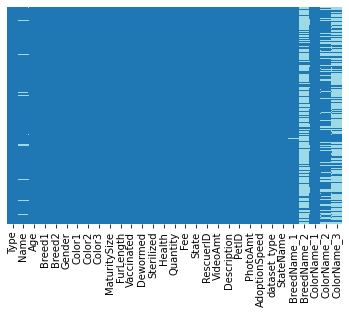

In [14]:
#verifica campos nulos - train
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='tab20')

In [15]:
# state population: https://en.wikipedia.org/wiki/Malaysia **
state_population = {
    41336: '3.300.000',
    41325: '2.072.000',
    41367: '2.000.000' ,
    41401: '1.887.674',
    41415: '99.500',
    41324: '932.700',
    41332: '1.098.000',
    41335: '1.443.365',
    41330: '2.258.428',
    41380: '227.025',
    41327: '1.648.000',
    41345: '3.120.040',
    41342: '2,619.000',
    41326: '5.000.000',
    41361: '1.125.000' }


In [16]:
train["state_population"] = train.State.map(state_population)

In [17]:
state_labels

,StateID,StateName
0,41336,Johor
1,41325,Kedah
2,41367,Kelantan
3,41401,Kuala Lumpur
4,41415,Labuan
5,41324,Melaka
6,41332,Negeri Sembilan
7,41335,Pahang
8,41330,Perak
9,41380,Perlis


In [18]:
train[["State",'StateName',"state_population"]]

,State,StateName,state_population
0,41326,Selangor,5.000.000
1,41326,Selangor,5.000.000
2,41326,Selangor,5.000.000
3,41326,Selangor,5.000.000
4,41326,Selangor,5.000.000
...,...,...,...
14988,41367,Kelantan,2.000.000
14989,41367,Kelantan,2.000.000
14990,41415,Labuan,99.500
14991,41415,Labuan,99.500


In [19]:
# Color1, Color2 e Color3
#flag1(1): apenas cor1
train['Color_f1'] = (pd.isnull(train['ColorName_3']) & pd.isnull(train['ColorName_2']) & pd.notnull(train['ColorName_1'])).astype(int)
#flag2(1): cor1 + cor2
train['Color_f2'] = (pd.isnull(train['ColorName_3']) & pd.notnull(train['ColorName_2']) & pd.notnull(train['ColorName_1'])).astype(int)
#flag3(1): todas 3 cores
train['Color_f3'] = (pd.notnull(train['ColorName_3']) & pd.notnull(train['ColorName_2']) & pd.notnull(train['ColorName_1'])).astype(int)

# Breed1 e Breed2
#flag1(1): apenas breed1
train['Breed_f1'] = (pd.isnull(train['BreedName_2']) & pd.notnull(train['BreedName_1'])).astype(int)
#train['Breed_f1'] = (train['Breed2'] == 0 & train['Breed1'] > 0 ).astype(int)
#flag2(1): breed1 + breed2
train['Breed_f2'] = (pd.notnull(train['BreedName_2']) & pd.notnull(train['BreedName_1'])).astype(int)



<AxesSubplot:>

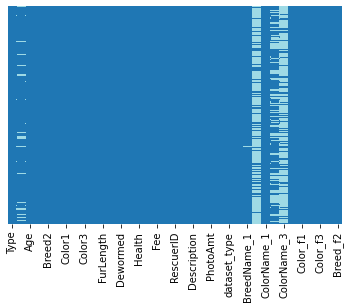

In [20]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='tab20')

In [21]:
#tratamento atributos
#Type
new_type = pd.Categorical(train["Type"])
new_type = new_type.rename_categories(["Dog","Cat"])              
train["Type_Desc"] = new_type

#Gender
new_Gender = pd.Categorical(train["Gender"])
new_Gender = new_Gender.rename_categories(["Macho","Fêmea","Mestiço"])              
train["Gender_Desc"] = new_Gender

#MaturitySize
new_MaturitySize = pd.Categorical(train["MaturitySize"])
new_MaturitySize = new_MaturitySize.rename_categories(["Pequeno","Médio","Grande","Extravagante"])              
train["MaturitySize_Desc"] = new_MaturitySize

#FurLength
new_FurLength = pd.Categorical(train["FurLength"])
new_FurLength = new_FurLength.rename_categories(["Curto","Médio","Longo"])              
train["FurLength_Desc"] = new_FurLength

#Health
new_Health = pd.Categorical(train["Health"])
new_Health = new_Health.rename_categories(["Saudável","Lesão leve","Lesão grave"])              
train["Health_Desc"] = new_Health

#Vaccinated
new_Vaccinated = pd.Categorical(train["Vaccinated"])
new_Vaccinated = new_Vaccinated.rename_categories(["Sim","Não","Sem info"])              
train["Vaccinated_Desc"] = new_Vaccinated

#Dewormed
new_Dewormed = pd.Categorical(train["Dewormed"])
new_Dewormed = new_Dewormed.rename_categories(["Sim","Não","Sem info"])                 
train["Dewormed_Desc"] = new_Dewormed

#Sterilized
new_Sterilized = pd.Categorical(train["Sterilized"])
new_Sterilized = new_Sterilized.rename_categories(["Sim","Não","Sem info"])                 
train["Sterilized_Desc"] = new_Sterilized

#Name (create a flag if the name is missing, with less than two letters)
train['Name_len']=train['Name'].str.len()
train['Name_missing'] =  (pd.isnull(train['Name'])).astype(int)

#Description 
train['Description_len']=train['Description'].str.len()

#PhotoAmt - No photo (1)
train['Photo_no'] =  (train['PhotoAmt']==0).astype(int)

#VideoAmt - No Video (1)
train['Video_no'] =  (train['VideoAmt']==0).astype(int)

# Fee - Fee free (1) se for taxa free
train['Fee_free'] =  (train['Fee']==0).astype(int)

#Age - No Age (1)
train['Age_no'] =  (train['Age']==0).astype(int)



In [22]:
# Normalize the Variable Description e Name
train['Description'] =train['Description'].fillna("<MISSING>")
train['Name'] =train['Name'].fillna("<MISSING>")
train['BreedName_1'] =train['BreedName_1'].fillna("<MISSING>")
train['BreedName_2'] =train['BreedName_2'].fillna("<MISSING>")
train['ColorName_2'] =train['ColorName_2'].fillna("<MISSING>")
train['ColorName_3'] =train['ColorName_3'].fillna("<MISSING>")


-------------------------------------------------------------------------------

# **4. ANALISE E EXPLORAÇÃO DE DADOS** <a class="anchor" id="4"></a>

[Topo](#0.1)


In [23]:
# análise incial - estatíticas
print('Data Statistics - train:')
train.describe()

Data Statistics - train:


,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,...,Color_f3,Breed_f1,Breed_f2,Name_len,Name_missing,Description_len,Photo_no,Video_no,Fee_free,Age_no
count,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,...,14993.000000,14993.000000,14993.000000,13736.000000,14993.000000,14981.000000,14993.000000,14993.000000,14993.000000,14993.000000
mean,1.457614,10.452078,265.272594,74.009738,1.776162,2.234176,3.222837,1.882012,1.862002,1.467485,...,0.292737,0.717201,0.281665,9.510993,0.083839,339.585141,0.022744,0.961715,0.844594,0.011939
std,0.498217,18.155790,60.056818,123.011575,0.681592,1.745225,2.742562,2.984086,0.547959,0.599070,...,0.455034,0.450374,0.449826,7.252954,0.277156,373.391094,0.149091,0.191889,0.362303,0.108615
min,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,2.000000,265.000000,0.000000,1.000000,1.000000,0.000000,0.000000,2.000000,1.000000,...,0.000000,0.000000,0.000000,5.000000,0.000000,117.000000,0.000000,1.000000,1.000000,0.000000
50%,1.000000,3.000000,266.000000,0.000000,2.000000,2.000000,2.000000,0.000000,2.000000,1.000000,...,0.000000,1.000000,0.000000,6.000000,0.000000,238.000000,0.000000,1.000000,1.000000,0.000000
75%,2.000000,12.000000,307.000000,179.000000,2.000000,3.000000,6.000000,5.000000,2.000000,2.000000,...,1.000000,1.000000,1.000000,12.000000,0.000000,432.000000,0.000000,1.000000,1.000000,0.000000
max,2.000000,255.000000,307.000000,307.000000,3.000000,7.000000,7.000000,7.000000,4.000000,3.000000,...,1.000000,1.000000,1.000000,47.000000,1.000000,6664.000000,1.000000,1.000000,1.000000,1.000000


In [24]:
# análise incial - estatíticas
print('Data Statistics - test:')
test.describe()

Data Statistics - test:


,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,VideoAmt,PhotoAmt
count,3972.000000,3972.000000,3972.000000,3972.000000,3972.000000,3972.000000,3972.000000,3972.000000,3972.000000,3972.000000,3972.000000,3972.000000,3972.000000,3972.000000,3972.000000,3972.000000,3972.000000,3972.000000,3972.000000
mean,1.471299,11.290534,263.628651,66.110775,1.769889,2.261581,3.277946,1.903575,1.848691,1.450655,1.697130,1.518127,1.895015,1.040534,1.597180,21.769637,41347.259063,0.042548,3.641742
std,0.499238,17.497150,60.241316,118.167713,0.688737,1.785615,2.745439,2.974756,0.553386,0.601209,0.675627,0.685074,0.598248,0.208407,1.500566,79.283772,32.965854,0.302682,3.373247
min,1.000000,0.000000,2.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,41324.000000,0.000000,0.000000
25%,1.000000,2.000000,265.000000,0.000000,1.000000,1.000000,0.000000,0.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,0.000000,41326.000000,0.000000,1.000000
50%,1.000000,4.000000,266.000000,0.000000,2.000000,1.000000,2.000000,0.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,0.000000,41327.000000,0.000000,3.000000
75%,2.000000,12.000000,307.000000,45.250000,2.000000,3.000000,6.000000,5.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,0.000000,41401.000000,0.000000,5.000000
max,2.000000,156.000000,307.000000,307.000000,3.000000,7.000000,7.000000,7.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,20.000000,1500.000000,41415.000000,8.000000,30.000000


### Visão geral dos atributos

array([[<AxesSubplot:title={'center':'Type'}>,
        <AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'Breed1'}>,
        <AxesSubplot:title={'center':'Breed2'}>,
        <AxesSubplot:title={'center':'Gender'}>,
        <AxesSubplot:title={'center':'Color1'}>],
       [<AxesSubplot:title={'center':'Color2'}>,
        <AxesSubplot:title={'center':'Color3'}>,
        <AxesSubplot:title={'center':'MaturitySize'}>,
        <AxesSubplot:title={'center':'FurLength'}>,
        <AxesSubplot:title={'center':'Vaccinated'}>,
        <AxesSubplot:title={'center':'Dewormed'}>],
       [<AxesSubplot:title={'center':'Sterilized'}>,
        <AxesSubplot:title={'center':'Health'}>,
        <AxesSubplot:title={'center':'Quantity'}>,
        <AxesSubplot:title={'center':'Fee'}>,
        <AxesSubplot:title={'center':'State'}>,
        <AxesSubplot:title={'center':'VideoAmt'}>],
       [<AxesSubplot:title={'center':'PhotoAmt'}>,
        <AxesSubplot:title={'center':'AdoptionSpee

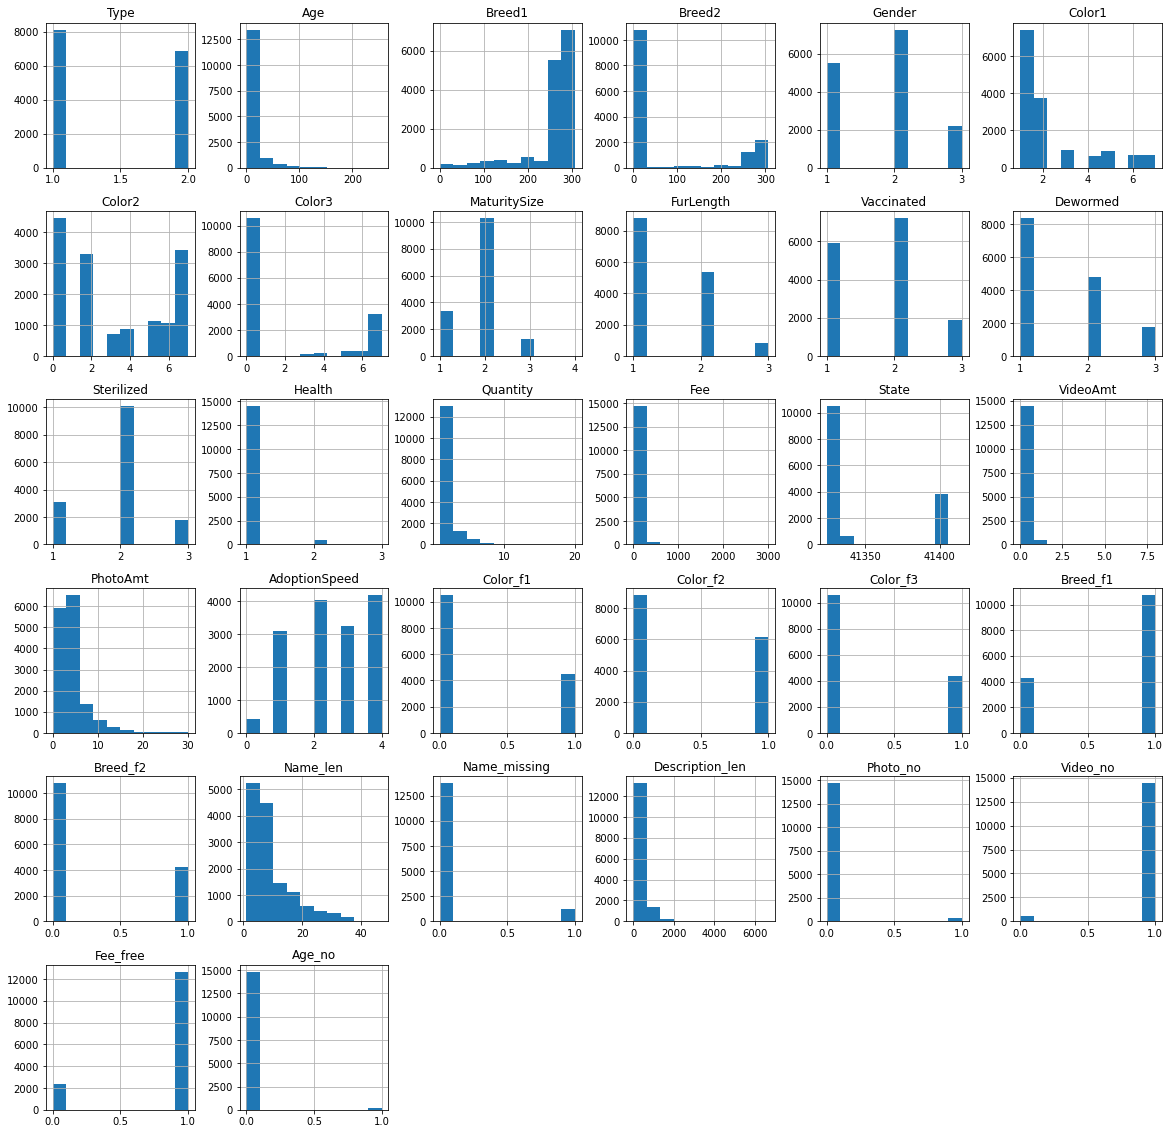

In [25]:
train.hist(figsize=(20,20))

###  AdoptionSpeed

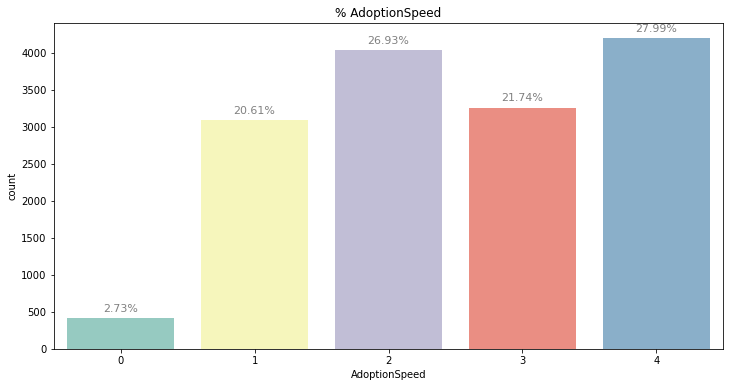

In [26]:
plt.figure(figsize=(12, 6));
g = sns.countplot(x='AdoptionSpeed', data=train,palette="Set3")
plt.title('% AdoptionSpeed');
ax=g.axes

for p in ax.patches:
     ax.annotate(f"{p.get_height() * 100 / train.shape[0]:.2f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
         ha='center', va='center', fontsize=11, color='gray', rotation=0, xytext=(0, 10),
         textcoords='offset points'
               ) 

### Type

([<matplotlib.patches.Wedge at 0x191d85f4d60>,
 [Text(-0.14604463102942658, 1.090261879434239, 'Dog'),
  Text(0.14604473310710966, -1.090261865760549, 'Cat')],
 [Text(-0.07966070783423268, 0.5946882978732211, '54.24%'),
  Text(0.0796607635129689, -0.5946882904148448, '45.76%')])

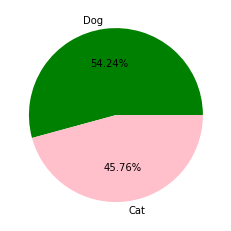

In [27]:
#Tipo
mylabels='Dog','Cat'
mycolors='green', 'pink'

plt.pie(train['Type'].value_counts(),
        labels=mylabels,autopct='%1.2f%%',
       colors=mycolors)

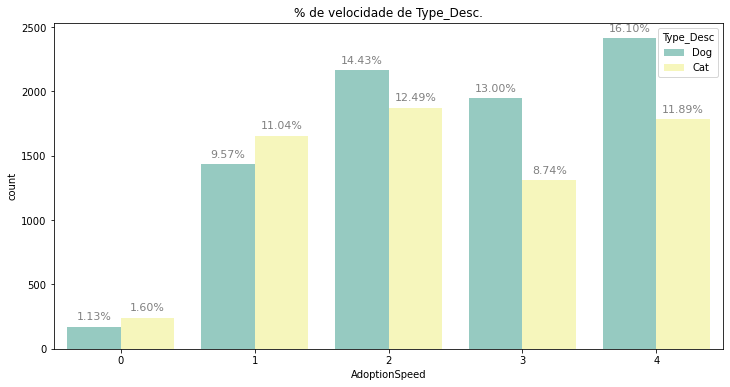

In [28]:
plt.figure(figsize=(12, 6),);
g = sns.countplot(x='AdoptionSpeed',  hue='Type_Desc',data=train,palette="Set3")
plt.title('% de velocidade de Type_Desc.');
ax=g.axes

for p in ax.patches:
     ax.annotate(f"{p.get_height() * 100 / train.shape[0]:.2f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
         ha='center', va='center', fontsize=11, color='gray', rotation=0, xytext=(0, 10),
         textcoords='offset points'
               ) 

 * ````Type```` nos primeiros dias (1º semana) os gatos são adotados mais rápidos do que os cachorros.

### Age

In [29]:
train['Age'].describe()

count    14993.000000
mean        10.452078
std         18.155790
min          0.000000
25%          2.000000
50%          3.000000
75%         12.000000
max        255.000000
Name: Age, dtype: float64

In [30]:
#distinct 
train.Age.unique()

array([  3,   1,  12,   0,   2,  78,   6,  10,  36,  14,   4,  24,   5,
        72,  60,  48,  47,   8,  32,   7, 120,  17,  13,  19,  11,  37,
        22,   9,  55,  20,  74,  18,  53,  25,  84,  76, 132,  16,  96,
        46,  15,  56,  50,  23,  30,  29,  27,  44, 144,  21,  51,  41,
       135,  52,  42,  54,  39,  31,  26,  38,  33,  75, 108,  95,  63,
        65,  61,  49,  62,  89,  34,  35,  73,  28, 122, 123,  64, 156,
        67,  82,  92, 168, 102,  77, 147,  80,  45,  85,  43,  57, 100,
       180,  81,  69,  91, 112,  40, 212, 255,  66,  68,  88, 117, 238,
        87,  86], dtype=int64)

Text(0.5, 0, 'Age (month)')

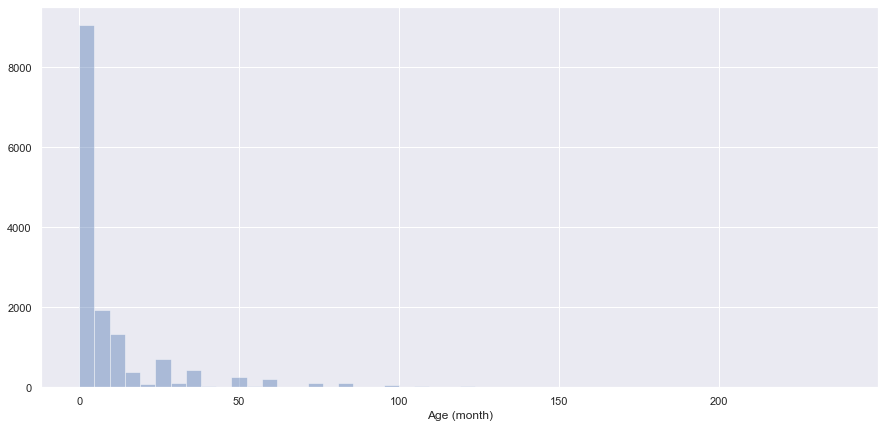

In [31]:
# set the size of the figure
sns.set(rc={'figure.figsize':(15,7)})

# plot a histogram showing the distribution of the target values
sns.distplot(train['Age'][train['Age'] < 255], kde=False)#bins=30)
plt.xlabel('Age (month)')

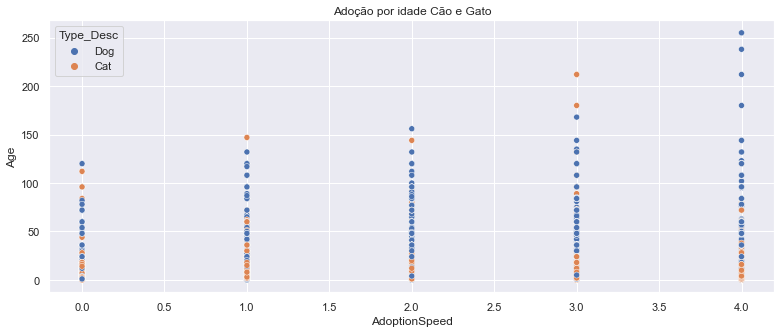

In [32]:
plt.figure(figsize=(13, 5));
sns.scatterplot(x="AdoptionSpeed", y="Age", hue="Type_Desc",data=train);
plt.title('Adoção por idade Cão e Gato');

Text(0.5, 1.0, 'AdoptionSpeed vs Age')

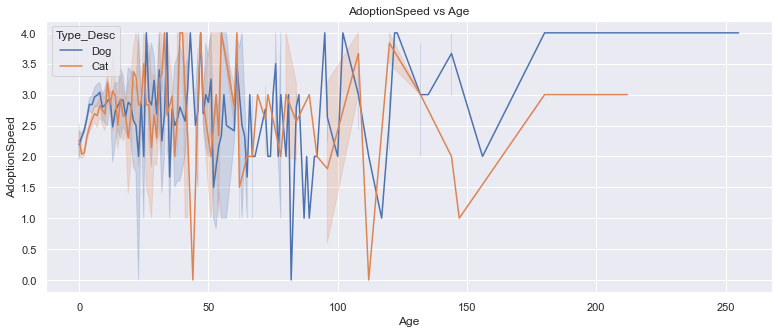

In [33]:
plt.figure(figsize=(13, 5));
sns.lineplot(x="Age", y="AdoptionSpeed", hue = "Type_Desc",data=train).set_title("AdoptionSpeed vs Age")

### Gender

<AxesSubplot:xlabel='Gender_Desc', ylabel='count'>

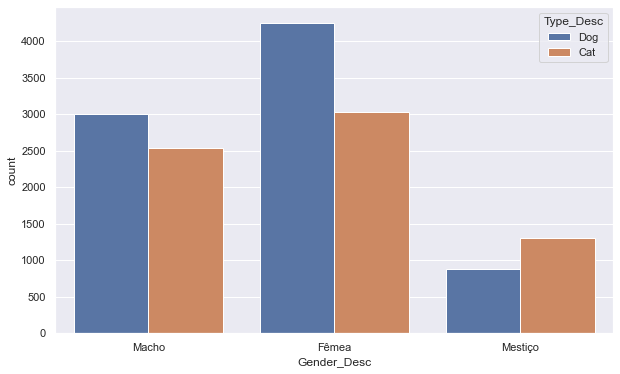

In [34]:
#Gender
plt.figure(figsize=(10, 6));
sns.countplot(x='Gender_Desc', hue='Type_Desc', data=train)

<AxesSubplot:xlabel='AdoptionSpeed', ylabel='count'>

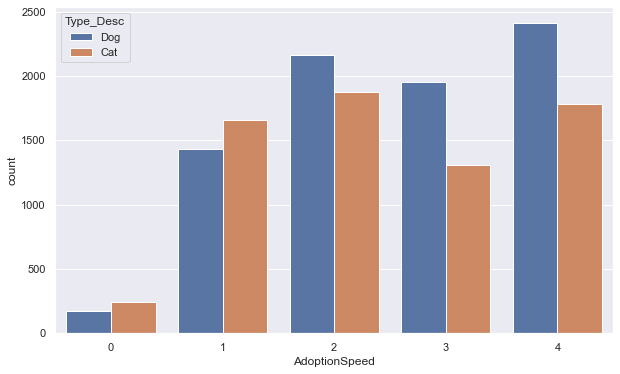

In [35]:
#Gender
plt.figure(figsize=(10, 6));
sns.countplot(x='AdoptionSpeed', hue='Type_Desc', data=train)

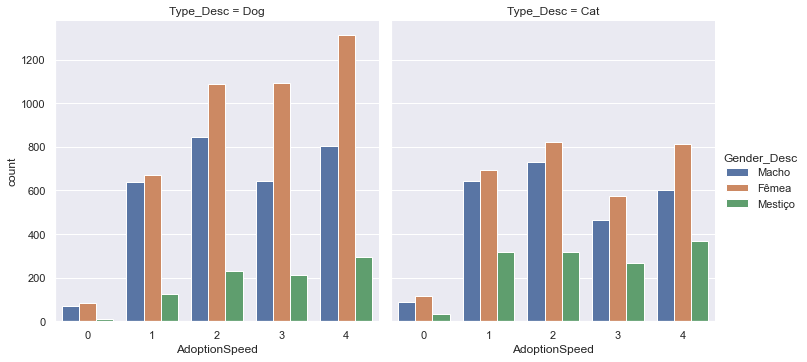

In [36]:
g = sns.catplot(x="AdoptionSpeed", hue="Gender_Desc", col="Type_Desc",
                data=train, kind="count",
                height=5, aspect=1);

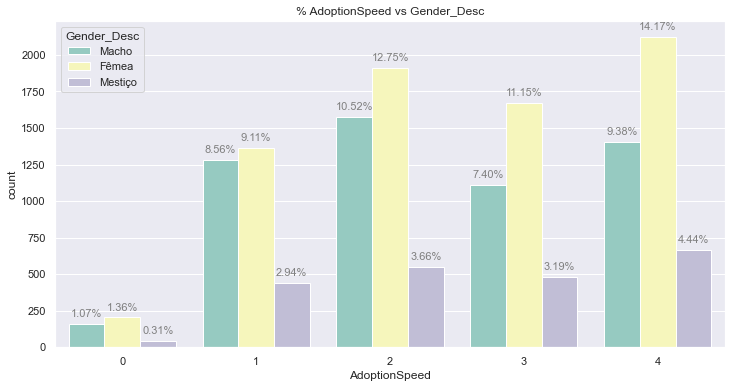

In [37]:
plt.figure(figsize=(12, 6));
g = sns.countplot(x='AdoptionSpeed',  hue='Gender_Desc',data=train,palette="Set3")
plt.title('% AdoptionSpeed vs Gender_Desc');
ax=g.axes

for p in ax.patches:
     ax.annotate(f"{p.get_height() * 100 / train.shape[0]:.2f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
         ha='center', va='center', fontsize=11, color='gray', rotation=0, xytext=(0, 10),
         textcoords='offset points'
               ) 

### MaturitySize

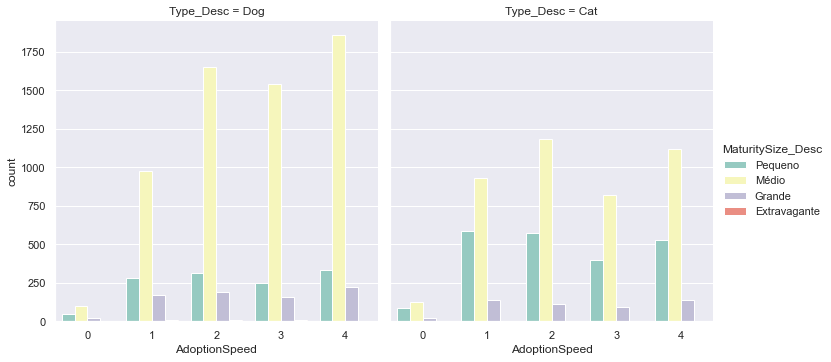

In [38]:
g = sns.catplot(x="AdoptionSpeed", hue="MaturitySize_Desc", col="Type_Desc",
                data=train, kind="count", palette="Set3",
                height=5, aspect=1);

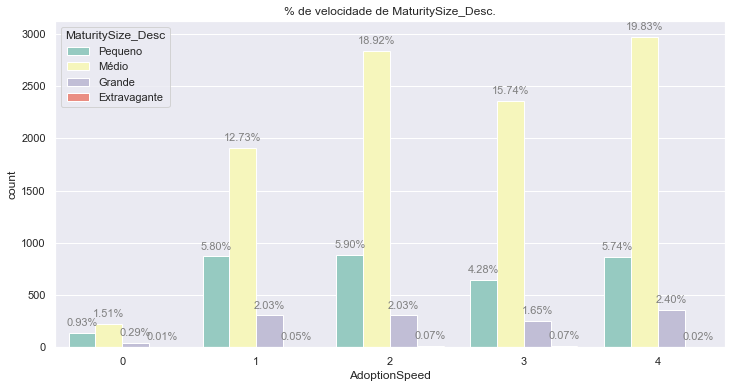

In [39]:
plt.figure(figsize=(12, 6));
g = sns.countplot(x='AdoptionSpeed',  hue='MaturitySize_Desc',data=train,palette="Set3")
plt.title('% de velocidade de MaturitySize_Desc.');
ax=g.axes

for p in ax.patches:
     ax.annotate(f"{p.get_height() * 100 / train.shape[0]:.2f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
         ha='center', va='center', fontsize=11, color='gray', rotation=0, xytext=(0, 10),
         textcoords='offset points'
               ) 

### FurLength

<AxesSubplot:xlabel='FurLength_Desc', ylabel='count'>

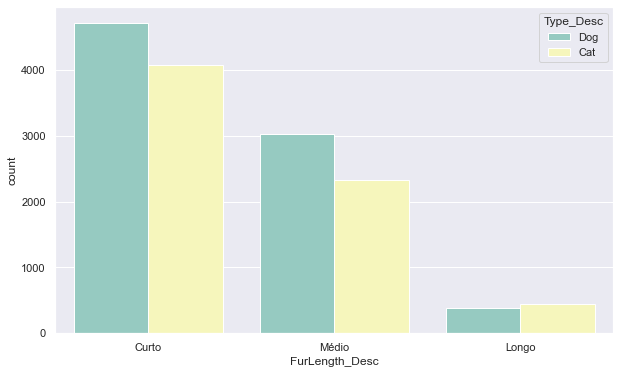

In [40]:
#MaturitySize_Desc
plt.figure(figsize=(10, 6));
sns.countplot(x='FurLength_Desc', hue='Type_Desc', palette="Set3",data=train)

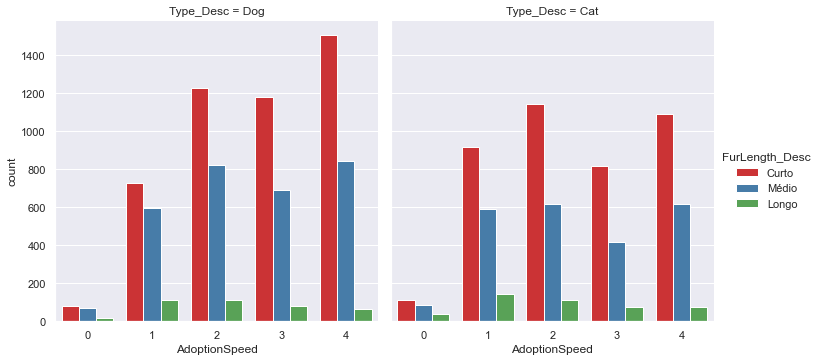

In [41]:
g = sns.catplot(x="AdoptionSpeed", hue="FurLength_Desc", col="Type_Desc",
                data=train, kind="count", palette="Set1",
                height=5, aspect=1);

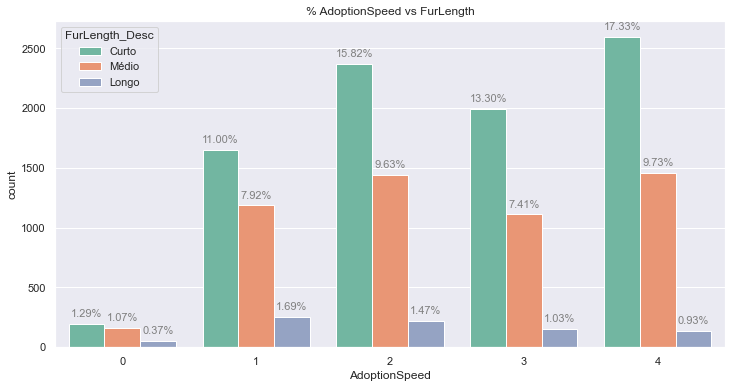

In [42]:
plt.figure(figsize=(12, 6));
g = sns.countplot(x='AdoptionSpeed',  hue='FurLength_Desc',data=train, palette="Set2")
plt.title('% AdoptionSpeed vs FurLength');
ax=g.axes

for p in ax.patches:
     ax.annotate(f"{p.get_height() * 100 / train.shape[0]:.2f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
         ha='center', va='center', fontsize=11, color='gray', rotation=0, xytext=(0, 10),
         textcoords='offset points'
               ) 

### Vaccinated, Dewormed, Sterilized e Health

In [43]:
#sáude
def simple_plot(train, column_name, plot_title=None):
    ax = sns.countplot(train[column_name])
    if plot_title is not None:
        ax.set(title = plot_title)
        set_values(ax)


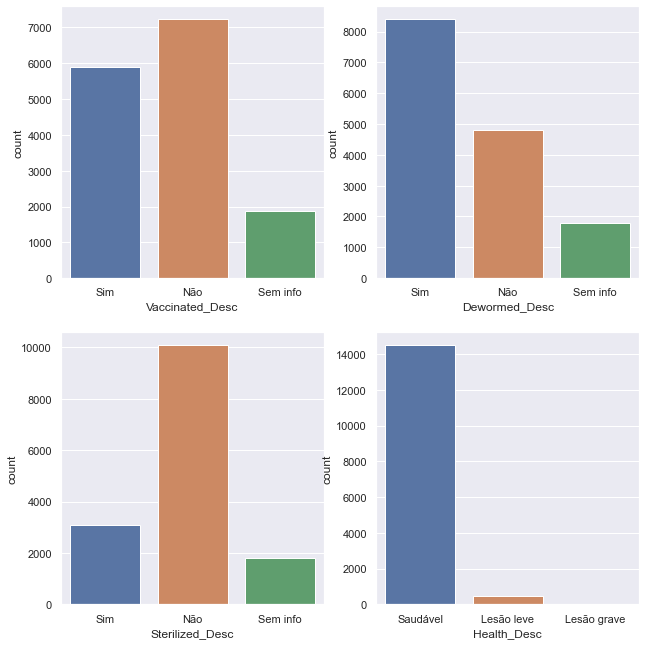

In [44]:

#plt.figure(figsize=(25,15))
plt.figure(figsize=(16,11))

plt.subplot(2,3,1)
simple_plot(train, 'Vaccinated_Desc')

plt.subplot(2,3,2)
simple_plot(train, 'Dewormed_Desc')

plt.subplot(2,3,4)
simple_plot(train, 'Sterilized_Desc')

plt.subplot(2,3,5)
simple_plot(train, 'Health_Desc')


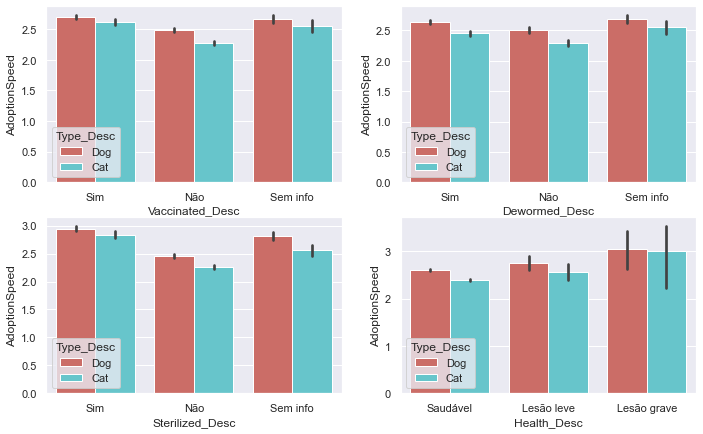

In [45]:
#Parte saúde: Veja que existe barra de erro MaturitySize e Health
plt.figure(figsize=(18,11))

plt.subplot(3,3,1)
sns.barplot(y='AdoptionSpeed', x='Vaccinated_Desc', hue='Type_Desc', palette ='hls',data=train);

plt.subplot(3,3,2)
sns.barplot(y='AdoptionSpeed', x='Dewormed_Desc', hue='Type_Desc', palette ='hls',data=train);

plt.subplot(3,3,4)
sns.barplot(y='AdoptionSpeed', x='Sterilized_Desc', hue='Type_Desc', palette ='hls',data=train);

plt.subplot(3,3,5)
sns.barplot(y='AdoptionSpeed', x='Health_Desc', hue='Type_Desc', palette ='hls',data=train);



### Vaccinated

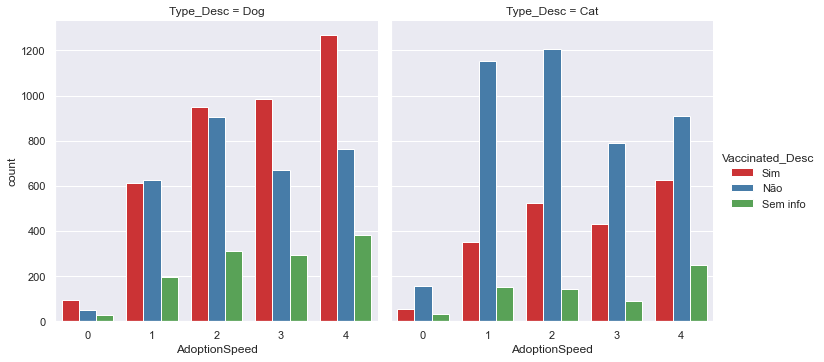

In [46]:
g = sns.catplot(x="AdoptionSpeed", hue="Vaccinated_Desc", col="Type_Desc",
                data=train, kind="count", palette="Set1",
                height=5, aspect=1);

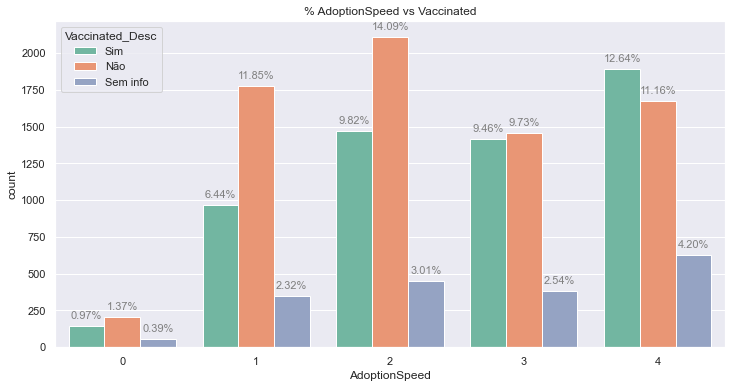

In [47]:
plt.figure(figsize=(12, 6));
g = sns.countplot(x='AdoptionSpeed',  hue='Vaccinated_Desc',data=train, palette="Set2")
plt.title('% AdoptionSpeed vs Vaccinated');
ax=g.axes

for p in ax.patches:
     ax.annotate(f"{p.get_height() * 100 / train.shape[0]:.2f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
         ha='center', va='center', fontsize=11, color='gray', rotation=0, xytext=(0, 10),
         textcoords='offset points'
               ) 

###  Dewormed

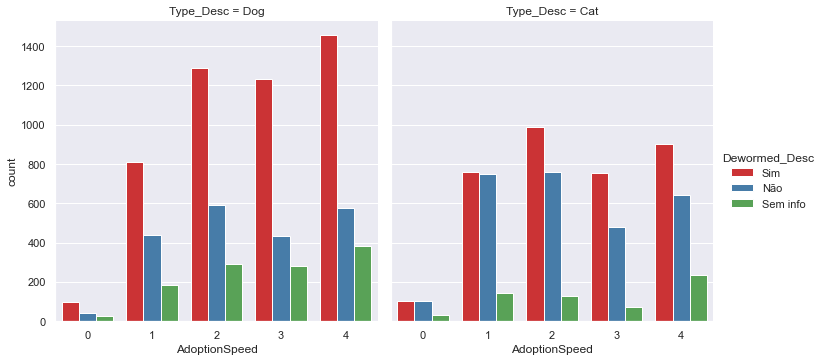

In [48]:
g = sns.catplot(x="AdoptionSpeed", hue="Dewormed_Desc", col="Type_Desc",
                data=train, kind="count", palette="Set1",
                height=5, aspect=1);

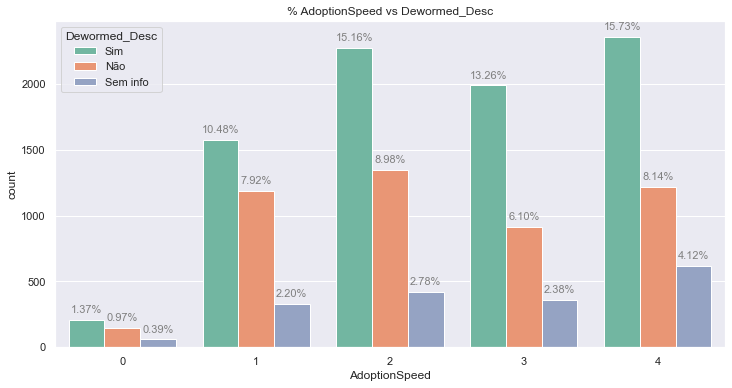

In [49]:
plt.figure(figsize=(12, 6));
g = sns.countplot(x='AdoptionSpeed',  hue='Dewormed_Desc',data=train, palette="Set2")
plt.title('% AdoptionSpeed vs Dewormed_Desc');
ax=g.axes

for p in ax.patches:
     ax.annotate(f"{p.get_height() * 100 / train.shape[0]:.2f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
         ha='center', va='center', fontsize=11, color='gray', rotation=0, xytext=(0, 10),
         textcoords='offset points'
               ) 

### Sterilized_Desc

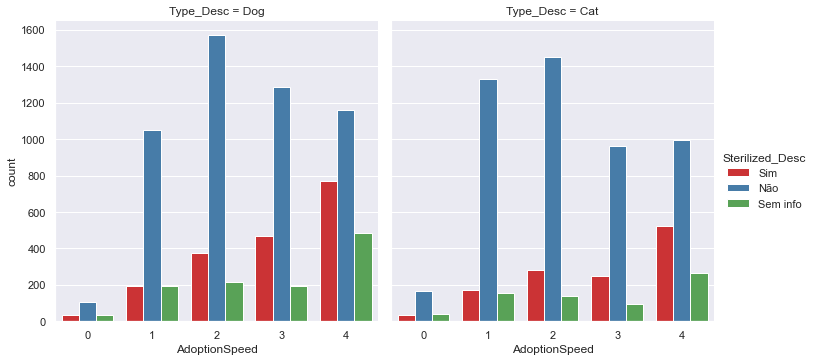

In [50]:
g = sns.catplot(x="AdoptionSpeed", hue="Sterilized_Desc", col="Type_Desc",
                data=train, kind="count", palette="Set1",
                height=5, aspect=1);

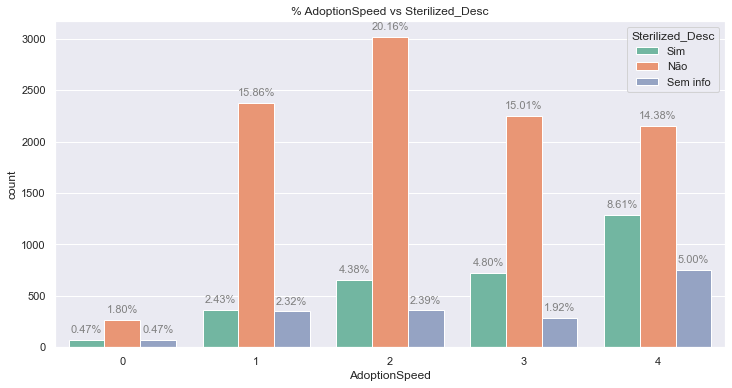

In [51]:
plt.figure(figsize=(12, 6));
g = sns.countplot(x='AdoptionSpeed',  hue='Sterilized_Desc',data=train, palette="Set2")
plt.title('% AdoptionSpeed vs Sterilized_Desc');
ax=g.axes

for p in ax.patches:
     ax.annotate(f"{p.get_height() * 100 / train.shape[0]:.2f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
         ha='center', va='center', fontsize=11, color='gray', rotation=0, xytext=(0, 10),
         textcoords='offset points'
               ) 

### Health_Desc

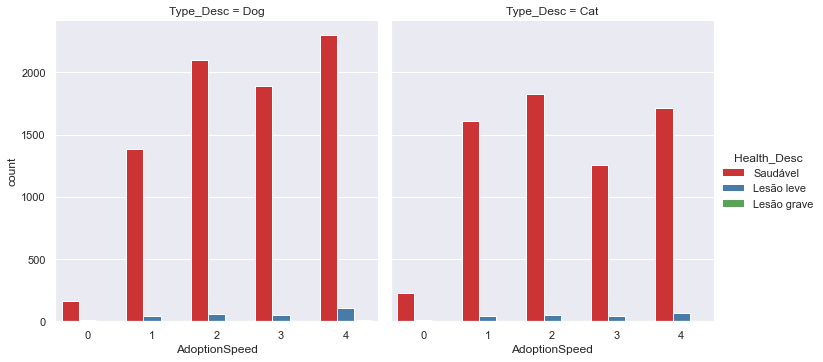

In [52]:
g = sns.catplot(x="AdoptionSpeed", hue="Health_Desc", col="Type_Desc",
                data=train, kind="count", palette="Set1",
                height=5, aspect=1);

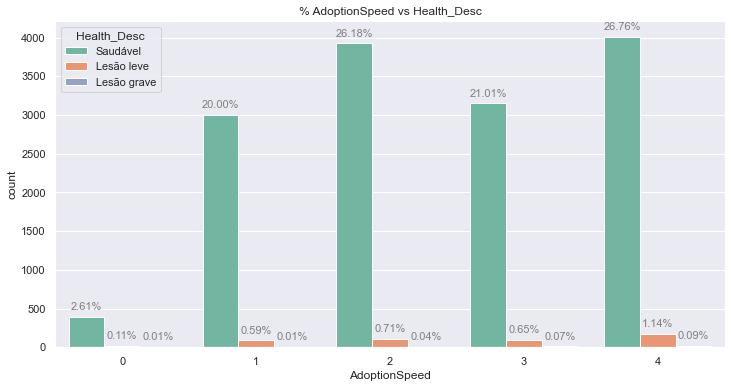

In [53]:
plt.figure(figsize=(12, 6));
g = sns.countplot(x='AdoptionSpeed',  hue='Health_Desc',data=train, palette="Set2")
plt.title('% AdoptionSpeed vs Health_Desc');
ax=g.axes

for p in ax.patches:
     ax.annotate(f"{p.get_height() * 100 / train.shape[0]:.2f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
         ha='center', va='center', fontsize=11, color='gray', rotation=0, xytext=(0, 10),
         textcoords='offset points'
               ) 

### Color1, Color2 e Color3

[Text(0.5, 1.0, 'First color')]

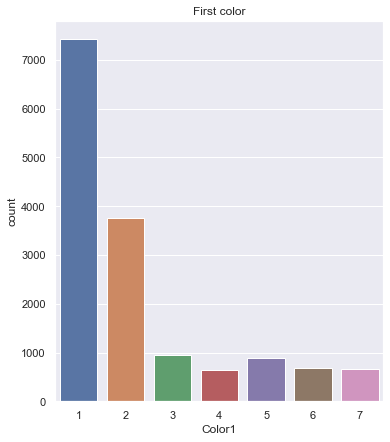

In [54]:
plt.figure(figsize=(20,7))

plt.subplot(1,3,1)
ax = sns.countplot(train['Color1'])
#sns.barplot(y='AdoptionSpeed', x='Color1', hue='Type_Desc', data=train);
ax.set(title='First color')

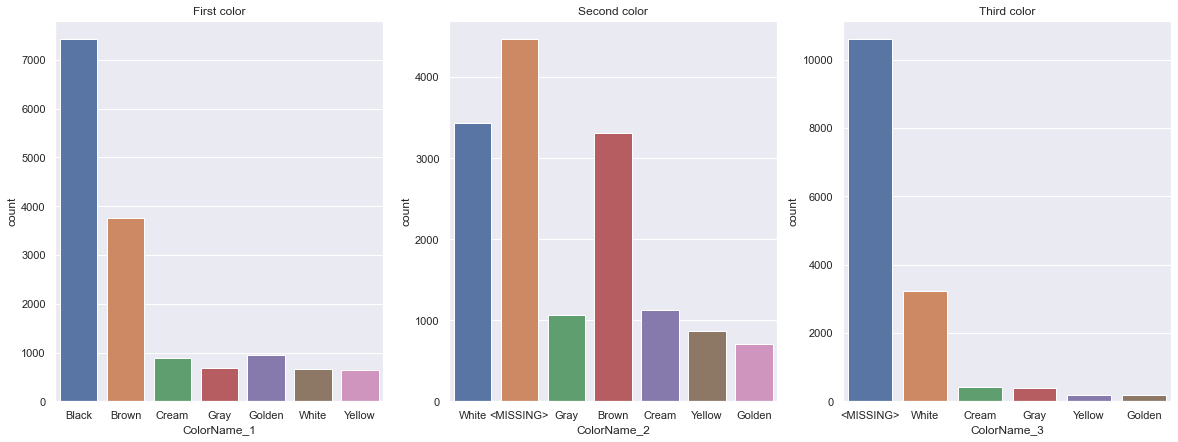

In [55]:
plt.figure(figsize=(20,7))

plt.subplot(1,3,1)
ax = sns.countplot(train['ColorName_1'])
#sns.barplot(y='AdoptionSpeed', x='Color1', hue='Type_Desc', data=train);
ax.set(title='First color')

plt.subplot(1,3,2)
ax = sns.countplot(train['ColorName_2'])
ax.set(title='Second color')

plt.subplot(1,3,3)
ax = sns.countplot(train['ColorName_3'])
_ = ax.set(title='Third color')

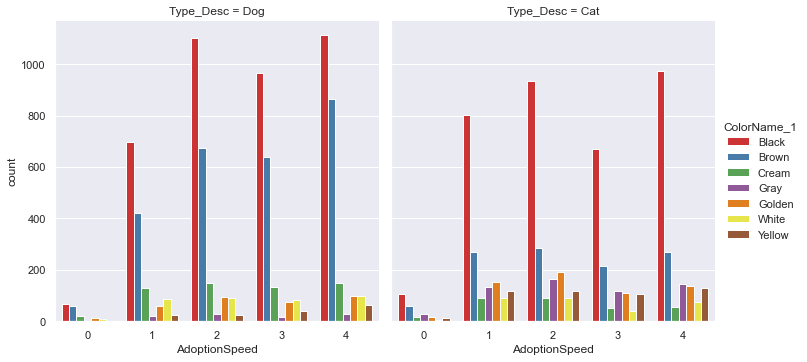

In [56]:
g = sns.catplot(x="AdoptionSpeed", hue="ColorName_1", col="Type_Desc",
                data=train, kind="count", palette="Set1",
                height=5, aspect=1);

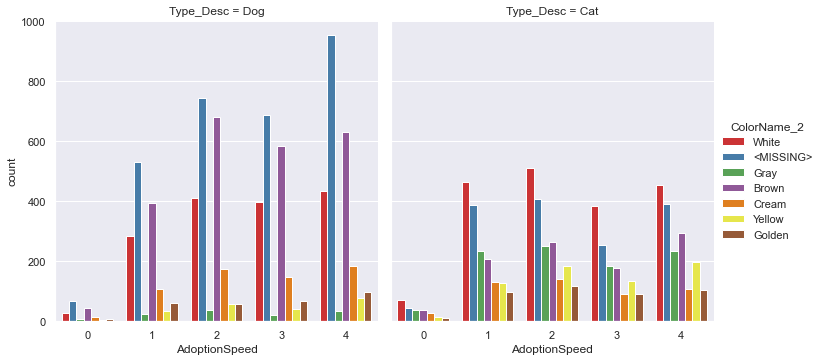

In [57]:
g = sns.catplot(x="AdoptionSpeed", hue="ColorName_2", col="Type_Desc",
                data=train, kind="count", palette="Set1",
                height=5, aspect=1);

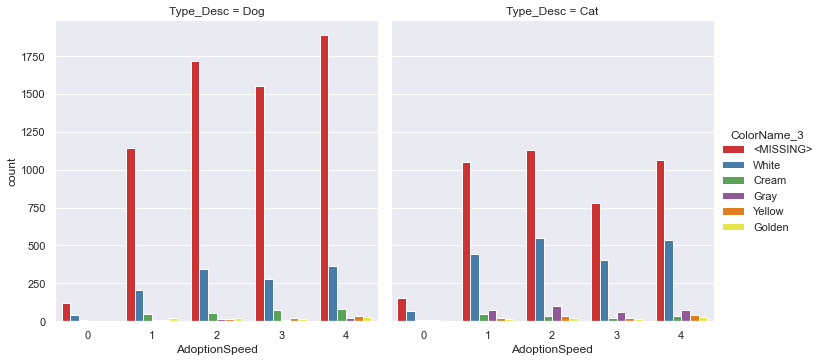

In [58]:
g = sns.catplot(x="AdoptionSpeed", hue="ColorName_3", col="Type_Desc",
                data=train, kind="count", palette="Set1",
                height=5, aspect=1);

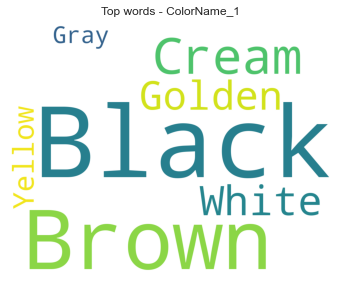

In [59]:
#Color1
fig, ax = plt.subplots(figsize = (9, 5))
text_ = ' '.join(train['ColorName_1'].loc[train['Type']==1].fillna('').values) #DOG

wordcloud = WordCloud(max_font_size=None, background_color='white',
                      width=1200, height=1000).generate(text_)
plt.imshow(wordcloud)
plt.title('Top words - ColorName_1');
plt.axis("off");

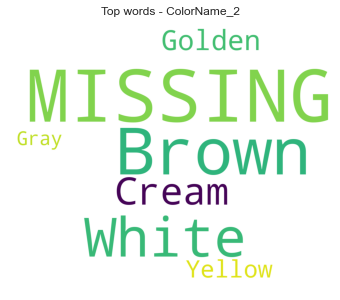

In [60]:
#Colo2
fig, ax = plt.subplots(figsize = (9, 5))
text_ = ' '.join(train['ColorName_2'].loc[train['Type']==1].fillna('').values) #DOG

wordcloud = WordCloud(max_font_size=None, background_color='white',
                      width=1200, height=1000).generate(text_)
plt.imshow(wordcloud)
plt.title('Top words - ColorName_2');
plt.axis("off");

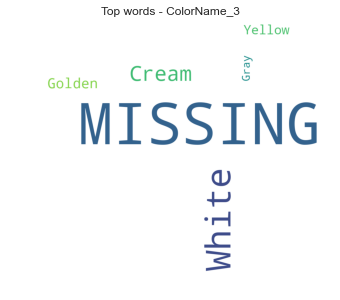

In [61]:
#Colo3
fig, ax = plt.subplots(figsize = (9, 5))
text_ = ' '.join(train['ColorName_3'].loc[train['Type']==1].fillna('').values) #DOG

wordcloud = WordCloud(max_font_size=None, background_color='white',
                      width=1200, height=1000).generate(text_)
plt.imshow(wordcloud)
plt.title('Top words - ColorName_3');
plt.axis("off");

### Breed1 e Breed2

<AxesSubplot:xlabel='AdoptionSpeed', ylabel='count'>

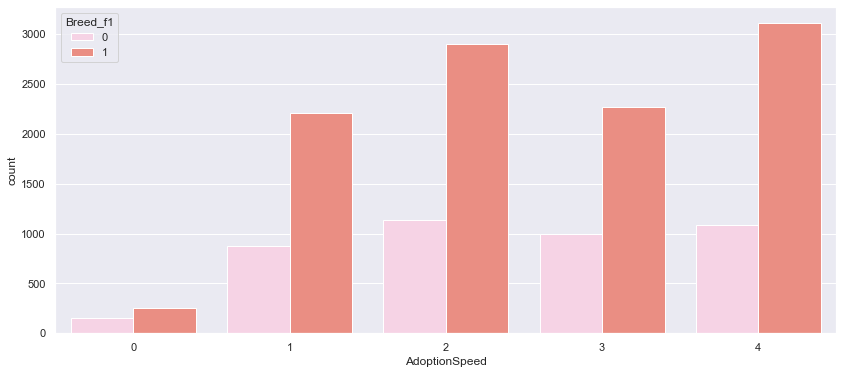

In [62]:
plt.figure(figsize=(14,6))
sns.countplot(x="AdoptionSpeed",hue="Breed_f1", palette="Set3_r",
              data=train)

<AxesSubplot:xlabel='AdoptionSpeed', ylabel='count'>

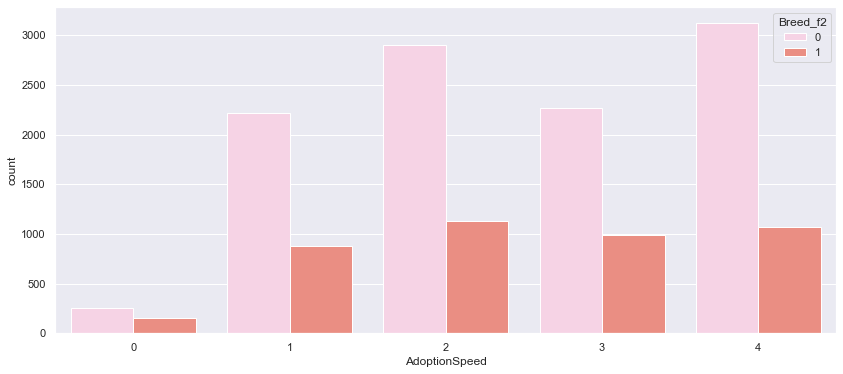

In [63]:
plt.figure(figsize=(14,6))
sns.countplot(x="AdoptionSpeed",hue="Breed_f2", palette="Set3_r",
              data=train)

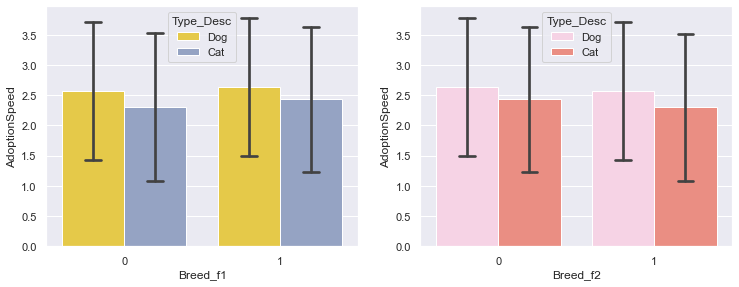

In [64]:
plt.figure(figsize=(19,15))
plt.subplot(3,3,1)
sns.barplot(y='AdoptionSpeed', x='Breed_f1', hue='Type_Desc', ci='sd', capsize=0.1, palette="Set2_r", data=train);

plt.subplot(3,3,2)
sns.barplot(y='AdoptionSpeed', x='Breed_f2', hue='Type_Desc', ci='sd', capsize=0.1,palette="Set3_r", data=train);


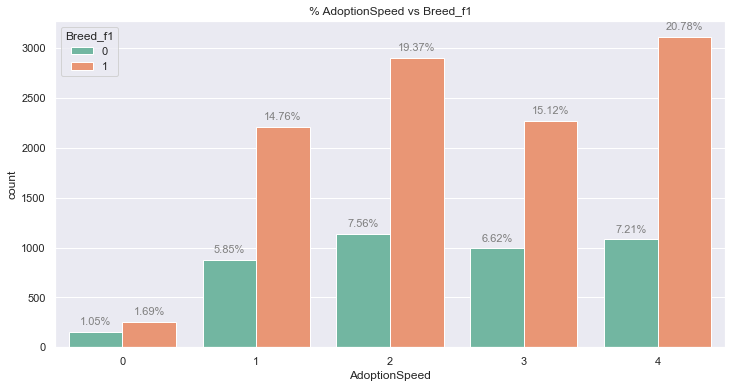

In [65]:
plt.figure(figsize=(12, 6));
g = sns.countplot(x='AdoptionSpeed',  hue='Breed_f1',data=train, palette="Set2")
plt.title('% AdoptionSpeed vs Breed_f1');
ax=g.axes

for p in ax.patches:
     ax.annotate(f"{p.get_height() * 100 / train.shape[0]:.2f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
         ha='center', va='center', fontsize=11, color='gray', rotation=0, xytext=(0, 10),
         textcoords='offset points'
               ) 

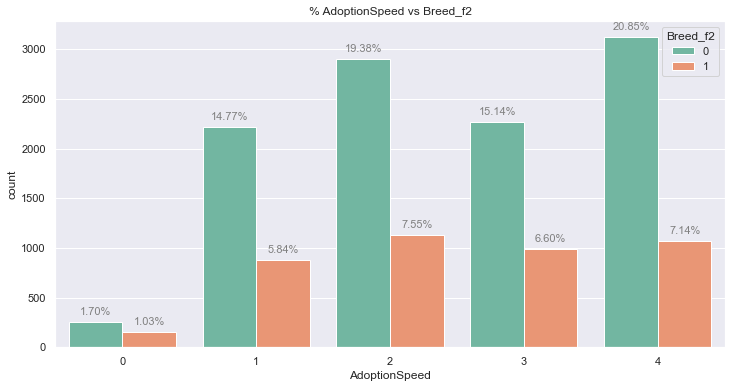

In [66]:
plt.figure(figsize=(12, 6));
g = sns.countplot(x='AdoptionSpeed',  hue='Breed_f2',data=train, palette="Set2")
plt.title('% AdoptionSpeed vs Breed_f2');
ax=g.axes

for p in ax.patches:
     ax.annotate(f"{p.get_height() * 100 / train.shape[0]:.2f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
         ha='center', va='center', fontsize=11, color='gray', rotation=0, xytext=(0, 10),
         textcoords='offset points'
               ) 

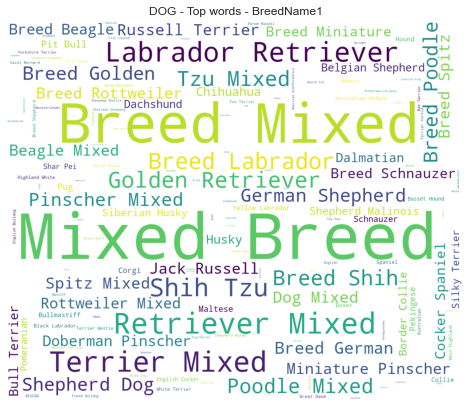

In [67]:
#Breed1 -DOC
fig, ax = plt.subplots(figsize = (11, 7))
text_ = ' '.join(train['BreedName_1'].loc[train['Type']==1].fillna('').values) #DOG

wordcloud = WordCloud(max_font_size=None, background_color='white',
                      width=1200, height=1000).generate(text_)
plt.imshow(wordcloud)
plt.title('DOG - Top words - BreedName1');
plt.axis("off");

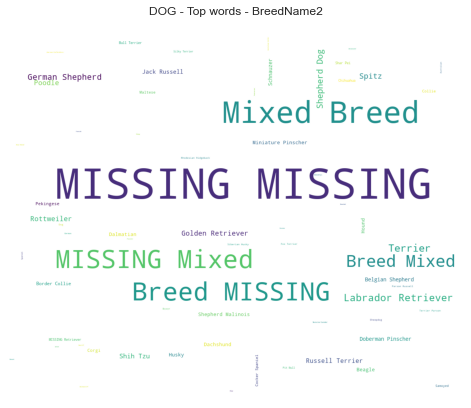

In [68]:
#Breed1 -DOG
fig, ax = plt.subplots(figsize = (11, 7))
text_ = ' '.join(train['BreedName_2'].loc[train['Type']==1].fillna('').values) #DOG

wordcloud = WordCloud(max_font_size=None, background_color='white',
                      width=1200, height=1000).generate(text_)
plt.imshow(wordcloud)
plt.title('DOG - Top words - BreedName2');
plt.axis("off");

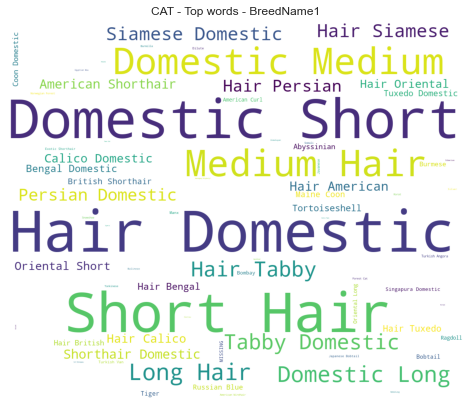

In [69]:
#Breed1 - cat
fig, ax = plt.subplots(figsize = (11, 7))
text_ = ' '.join(train['BreedName_1'].loc[train['Type']==2].fillna('').values) # CAT

wordcloud = WordCloud(max_font_size=None, background_color='white',
                      width=1200, height=1000).generate(text_)
plt.imshow(wordcloud)
plt.title('CAT - Top words - BreedName1');
plt.axis("off");

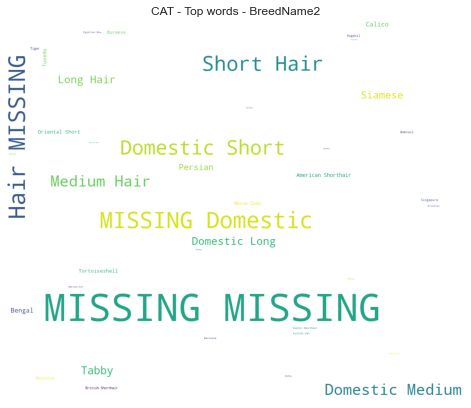

In [70]:
#Breed1 - cat
fig, ax = plt.subplots(figsize = (11, 7))
text_ = ' '.join(train['BreedName_2'].loc[train['Type']==2].fillna('').values) #CAT

wordcloud = WordCloud(max_font_size=None, background_color='white',
                      width=1200, height=1000).generate(text_)
plt.imshow(wordcloud)
plt.title('CAT - Top words - BreedName2');
plt.axis("off");

### Quantity

<AxesSubplot:xlabel='Quantity', ylabel='count'>

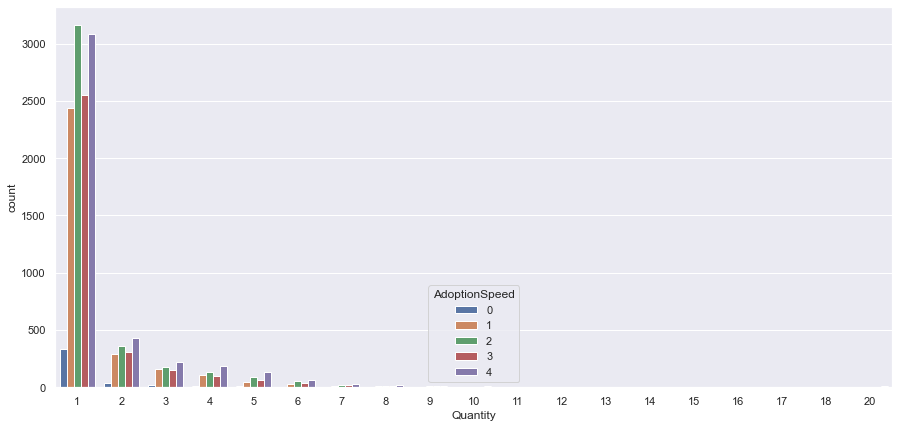

In [71]:
plt.figure(figsize=(15, 7));
sns.countplot(x='Quantity',hue='AdoptionSpeed',data=train)

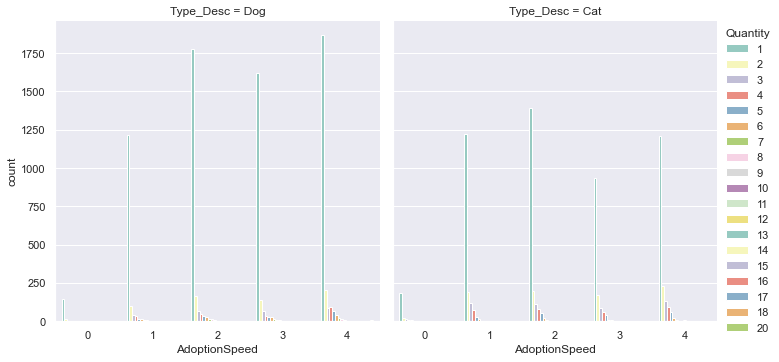

In [72]:
g = sns.catplot(x="AdoptionSpeed", hue="Quantity", col="Type_Desc",
                data=train, kind="count", palette="Set3",
                height=5, aspect=1);

### Fee

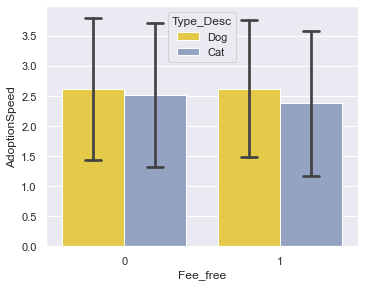

In [73]:
plt.figure(figsize=(19,15))
plt.subplot(3,3,1)
sns.barplot(y='AdoptionSpeed', x='Fee_free', hue='Type_Desc', ci='sd', capsize=0.1, palette="Set2_r", data=train);

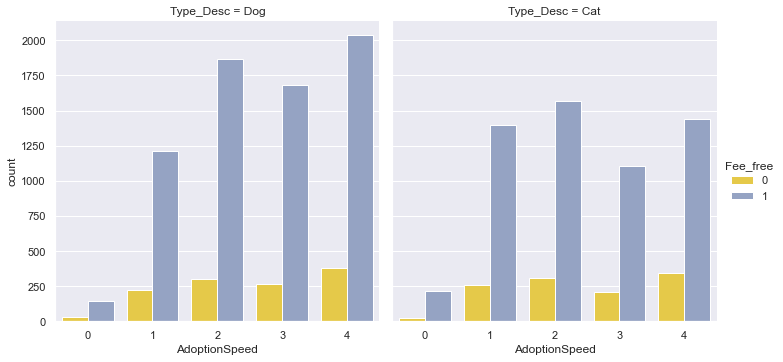

In [74]:
g = sns.catplot(x="AdoptionSpeed", hue="Fee_free", col="Type_Desc",
                data=train, kind="count", palette="Set2_r",
                height=5, aspect=1);

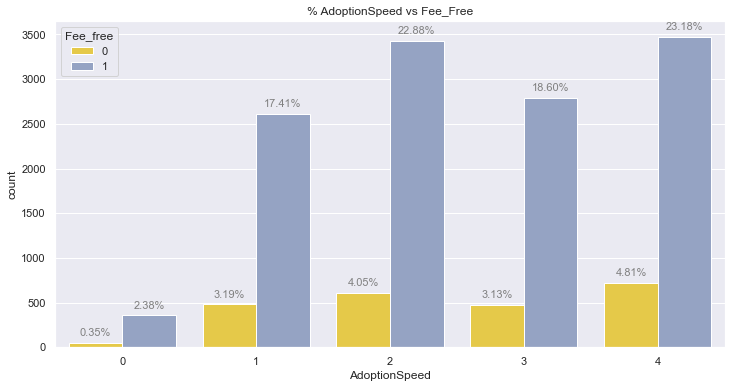

In [75]:
plt.figure(figsize=(12, 6));
g = sns.countplot(x='AdoptionSpeed',  hue='Fee_free',data=train, palette="Set2_r")
plt.title('% AdoptionSpeed vs Fee_Free');
ax=g.axes

for p in ax.patches:
     ax.annotate(f"{p.get_height() * 100 / train.shape[0]:.2f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
         ha='center', va='center', fontsize=11, color='gray', rotation=0, xytext=(0, 10),
         textcoords='offset points'
               ) 

### StateName

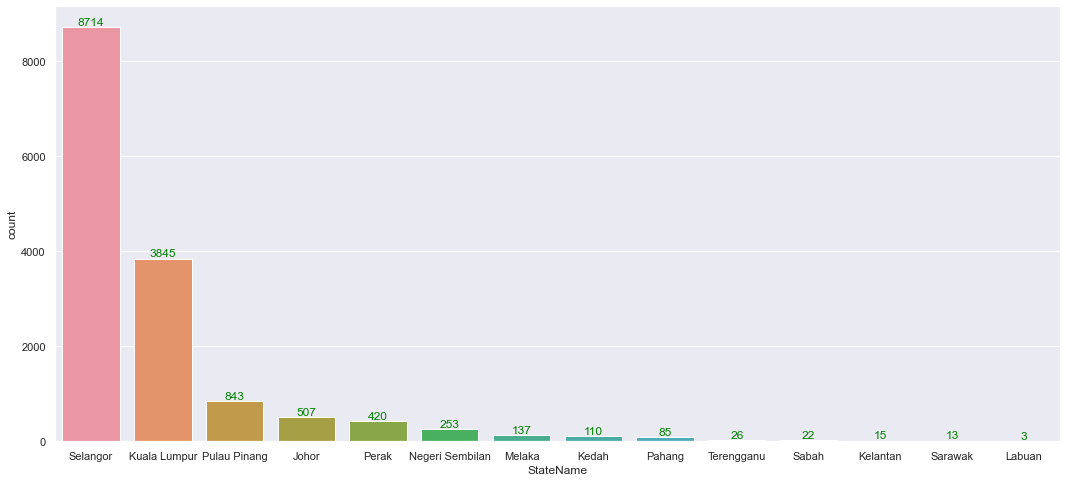

In [76]:
fig= plt.subplots(figsize=(18,8))
ax = sns.countplot(x="StateName", data=train, order = train["StateName"].value_counts().index )

# Iterate through the list of axes' patches
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=12, color='green', ha='center', va='bottom')

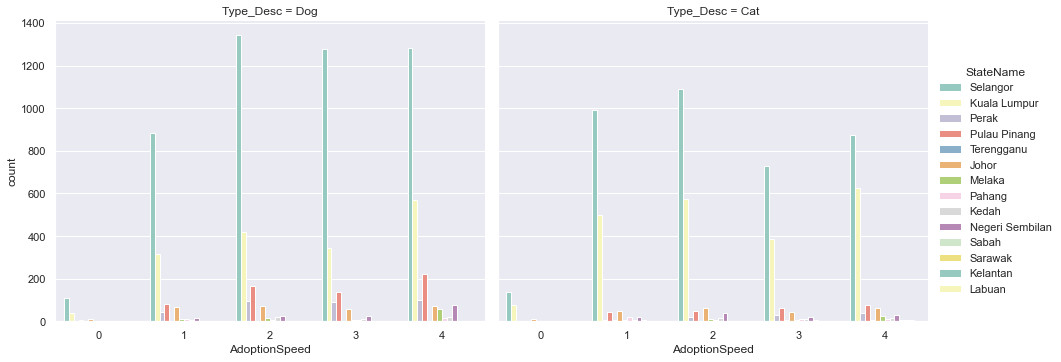

In [77]:
g = sns.catplot(x="AdoptionSpeed", hue="StateName", col="Type_Desc",
                data=train, kind="count", palette="Set3",
                height=5, aspect=1.3);

### PhotoAmt

In [78]:
train['PhotoAmt'].describe()

count    14993.000000
mean         3.889215
std          3.487810
min          0.000000
25%          2.000000
50%          3.000000
75%          5.000000
max         30.000000
Name: PhotoAmt, dtype: float64

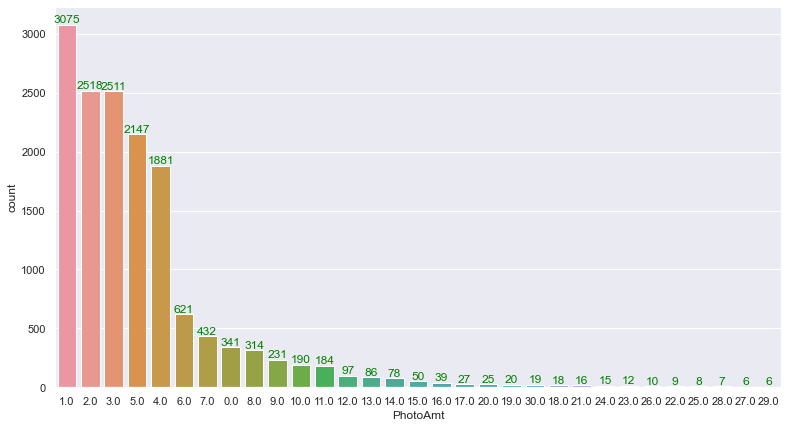

In [79]:
fig= plt.subplots(figsize=(13,7))
ax = sns.countplot(x="PhotoAmt", data=train, order = train["PhotoAmt"].value_counts().index )

# Iterate through the list of axes' patches
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=12, color='green', ha='center', va='bottom')

<AxesSubplot:xlabel='PhotoAmt', ylabel='count'>

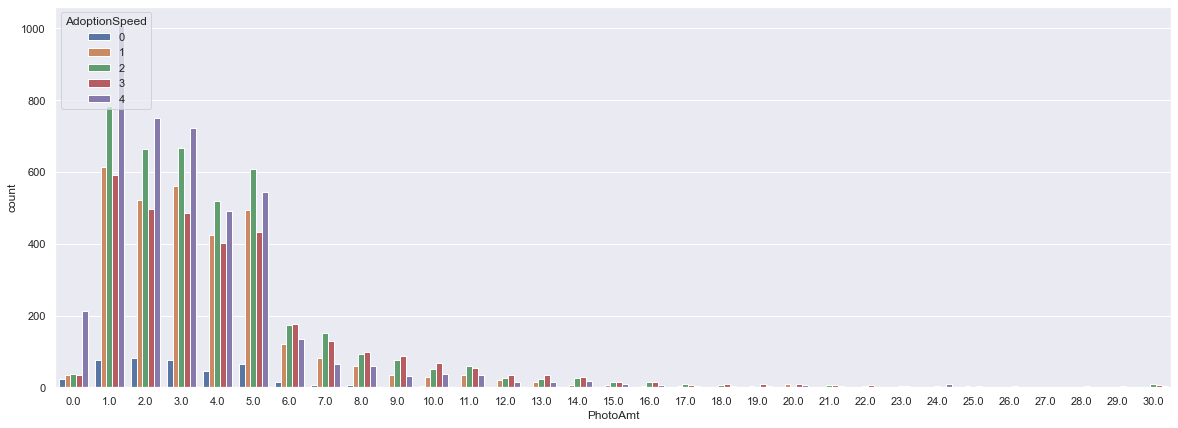

In [80]:
#PhotoAmt
plt.figure(figsize=(20, 7));
sns.countplot(x='PhotoAmt',hue='AdoptionSpeed',data=train)


Text(0.5, 1.0, 'AdoptionSpeed vs PhotoAmt')

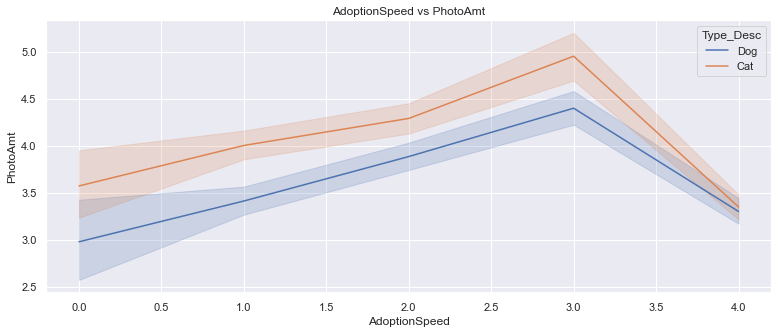

In [81]:
plt.figure(figsize=(13, 5));
sns.lineplot(x="AdoptionSpeed", y="PhotoAmt", hue = "Type_Desc",data=train).set_title("AdoptionSpeed vs PhotoAmt")

### VideoAmt

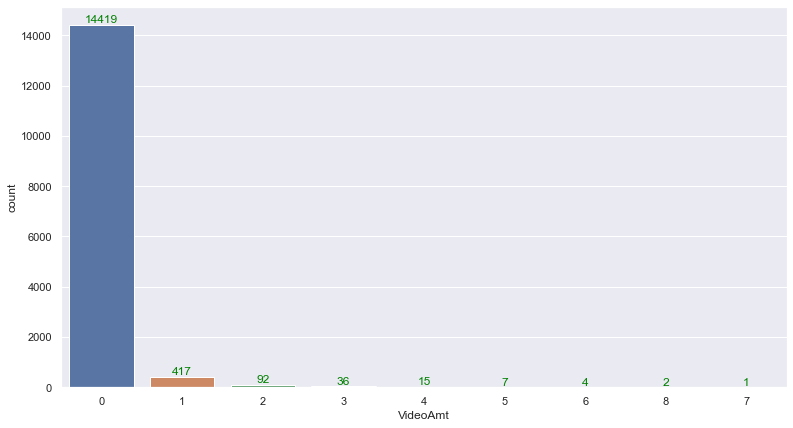

In [82]:
fig= plt.subplots(figsize=(13,7))
ax = sns.countplot(x="VideoAmt", data=train, order = train["VideoAmt"].value_counts().index )

# Iterate through the list of axes' patches
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=12, color='green', ha='center', va='bottom')

<AxesSubplot:xlabel='VideoAmt', ylabel='count'>

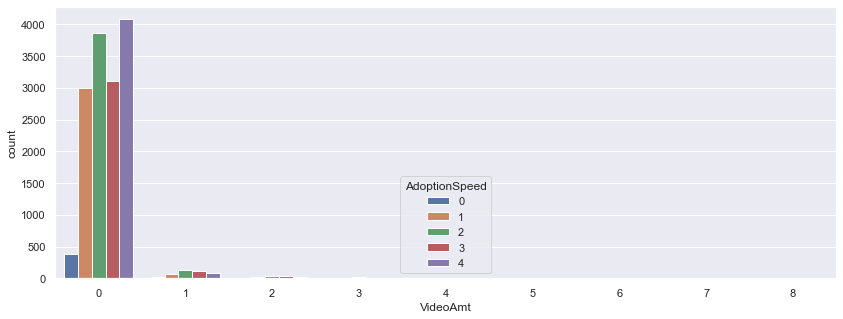

In [83]:
#VideoAmt
plt.figure(figsize=(14, 5));
sns.countplot(x='VideoAmt',hue='AdoptionSpeed',data=train)

------------------------------------------------------------------------------
# **4.1. Matrix de Correlação** <a class="anchor" id="4.1"></a>

[Topo](#0.1)

In [84]:
train = df_all.loc[df_all['dataset_type'] == 'train']

In [85]:
#remover - train
train = train.drop(['Description', 'Name', 'RescuerID', 'PetID','dataset_type'], axis=1)


In [86]:
#Precisamos converter todos os valores únicos em inteiros. Assim, realizamos a codificação do rótulo nos dados.
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()

for col in train.columns:
    train[col] = labelencoder.fit_transform(train[col])
    

Text(0.5, 1.0, 'Correlação entre variáveis do dataset')

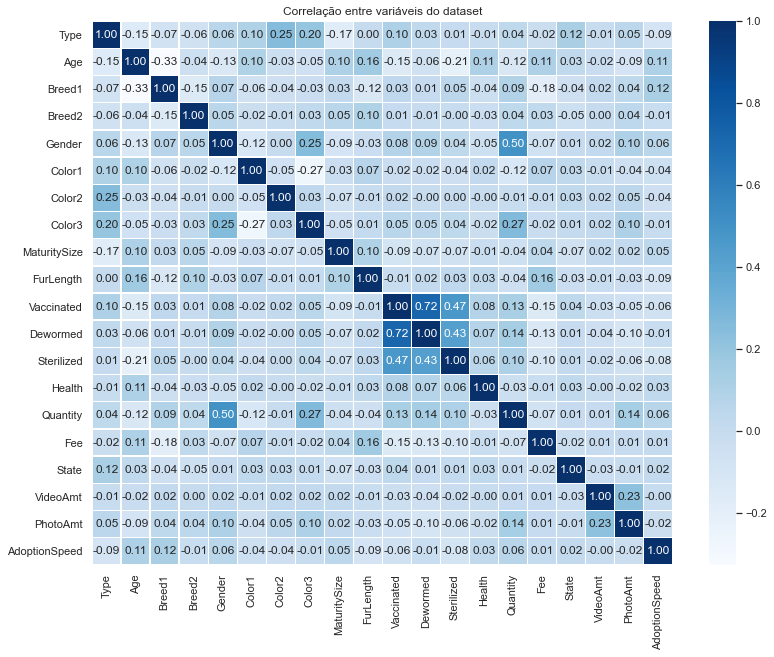

In [87]:
#relação dos atributos
f,ax = plt.subplots(figsize=(13, 10))
sns.heatmap(train.corr(), annot=True, linewidths=.5, fmt= '.2f',cmap='Blues',ax=ax)
plt.title('Correlação entre variáveis do dataset')

------------------------------------------------------------------------------
# **5. CONSTRUÇÃO DE MODELO** <a class="anchor" id="5"></a>

[Topo](#0.1)


In [88]:
X, y = train.loc[:, train.columns != 'AdoptionSpeed'], train['AdoptionSpeed']

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

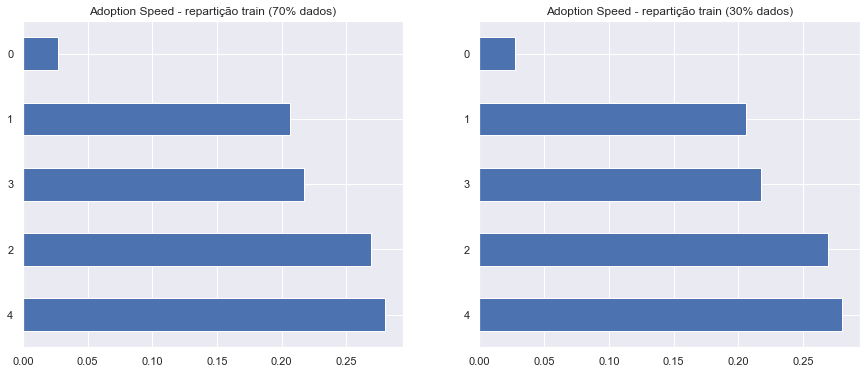

In [90]:
plt.subplot(1, 2, 1)
prob_train=y_train.value_counts(normalize=True)
prob_train.plot(kind='barh',figsize =(15,6))
plt.title('Adoption Speed - repartição train (70% dados)')
plt.subplot(1, 2, 2)

prob=y_test.value_counts(normalize=True)
prob.plot(kind='barh', figsize =(15,6))
plt.title('Adoption Speed - repartição train (30% dados)')
plt.show()

-------------------------------------------------------------------------------
# **5.1. Modelos - diversos** <a class="anchor" id="5.1"></a>

* Sem/Com valor de hiperparâmetro

[Topo](#0.1)


KNeighborsClassifier
Acurária - treinamento de 98.57%
Acurária de 33.57%
Matriz de confusão: 
 [[ 16  37  35  13  22]
 [ 39 308 274 167 139]
 [ 29 266 386 280 250]
 [ 20 172 261 283 242]
 [ 15 202 303 222 517]]
Relatório de classificação: 
               precision    recall  f1-score   support

           0       0.13      0.13      0.13       123
           1       0.31      0.33      0.32       927
           2       0.31      0.32      0.31      1211
           3       0.29      0.29      0.29       978
           4       0.44      0.41      0.43      1259

    accuracy                           0.34      4498
   macro avg       0.30      0.30      0.30      4498
weighted avg       0.34      0.34      0.34      4498

LGBMClassifier
Acurária - treinamento de 98.20%
Acurária de 37.33%
Matriz de confusão: 
 [[  8  39  39  17  20]
 [  7 301 283 180 156]
 [  4 239 433 257 278]
 [  2 148 274 283 271]
 [  1 148 279 177 654]]
Relatório de classificação: 
               precision    recall  

<AxesSubplot:>

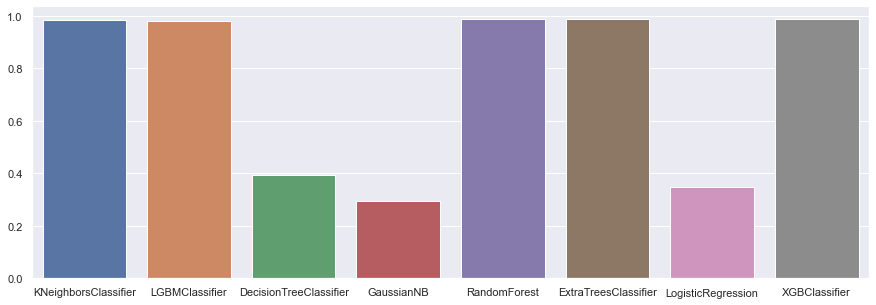

In [91]:
#treinar modelos
rotular = [  
    {"name": "KNeighborsClassifier", "Objeto": KNeighborsClassifier(1)},      
    {"name": "LGBMClassifier", "Objeto": LGBMClassifier(n_estimators=550, num_leaves=250,max_depth=10)},        
    {"name": "DecisionTreeClassifier", "Objeto": DecisionTreeClassifier(max_depth=5)},  
    {"name": "GaussianNB", "Objeto": GaussianNB(priors=None, var_smoothing=1.0)},       
    {"name": "RandomForest", "Objeto": RandomForestClassifier(n_estimators=170, random_state=0)},     
    {"name": "ExtraTreesClassifier", "Objeto":ExtraTreesClassifier(n_estimators=120)},   
    {"name": "LogisticRegression", "Objeto":LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
        intercept_scaling=1, l1_ratio=None, max_iter=100,       multi_class='ovr', #multiclass
        n_jobs=1, penalty='l2',random_state=None, solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)},        
    {"name": "XGBClassifier", "Objeto": XGBClassifier(n_estimators=100, max_depth=19)}
]

for clf in rotular:
    clf["Objeto"].fit(X_train, y_train)
    y_pred = clf["Objeto"].predict(X_test)
    
    clf["score"] = clf["Objeto"].score(X_train,y_train)
    clf["accuracyScore"] = accuracy_score(y_test,y_pred)
    
    print("%s"% (clf["name"]))
    print("Acurária - treinamento de {:.2f}%".format(clf["score"]*100))
    print("Acurária de {:.2f}%".format(clf["accuracyScore"]*100))
    print("Matriz de confusão: \n",confusion_matrix(y_test, y_pred))
    print("Relatório de classificação: \n", classification_report(y_test, y_pred))
    
names = [clf['name'] for clf in rotular]
scores = [clf['score'] for clf in rotular]

plt.figure(figsize=(15, 5))
sns.barplot(x=names, y=scores)


-------------------------------------------------------------------------------
# **5.2. RandomForestClassifier** <a class="anchor" id="5.2"></a>

* Ajuste hiperparâmetros

[Topo](#0.1)


<AxesSubplot:>

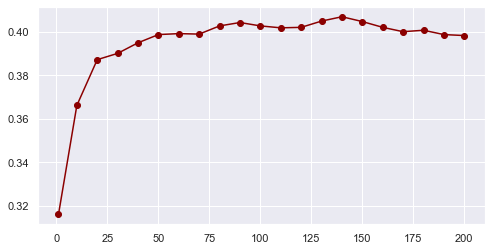

In [92]:
#opcao hiperparametro
results = []
n_options = [1,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200]

for x in n_options:
    #model_RFC = RandomForestClassifier(x, oob_score=True, n_jobs=-1, random_state=4)
    model_RFC = RandomForestClassifier(x, random_state=4)
    model_RFC.fit(X_train, y_train)
    
    y_pred = model_RFC.predict(X_test)
    accuracy = np.mean(y_test==y_pred)
    results.append(accuracy)

plt.figure(figsize=(8,4))
pd.Series(results, n_options).plot(color="darkred",marker="o")

In [93]:
model_RFC = RandomForestClassifier (n_estimators=140,  random_state=4)
#model_RFC = RandomForestClassifier ( random_state=4)
model_RFC.fit(X_train,y_train) #treinar modelo

#treina o modelo
result = model_RFC.score(X_train, y_train) 
print("Acurária - treinamento de {:.2f}%.".format(result*100))

#testa a acurácia do modelo com os dados de teste
pred = model_RFC.predict(X_test) 

#gera acurácia do modelo
print("Acurácia de {:.2f}%.".format(accuracy_score(y_test, pred)*100)) 
#print("Matriz de confusão:")
#print(confusion_matrix(y_test, pred),"\n") 
print("Classification report:")
print(classification_report(y_test, pred,digits=2),"\n")  


Acurária - treinamento de 98.64%.
Acurácia de 40.71%.
Classification report:
              precision    recall  f1-score   support

           0       0.40      0.07      0.11       123
           1       0.37      0.34      0.35       927
           2       0.35      0.38      0.37      1211
           3       0.38      0.29      0.33       978
           4       0.48      0.61      0.54      1259

    accuracy                           0.41      4498
   macro avg       0.40      0.34      0.34      4498
weighted avg       0.40      0.41      0.40      4498
 



### Matriz Confusão (train)

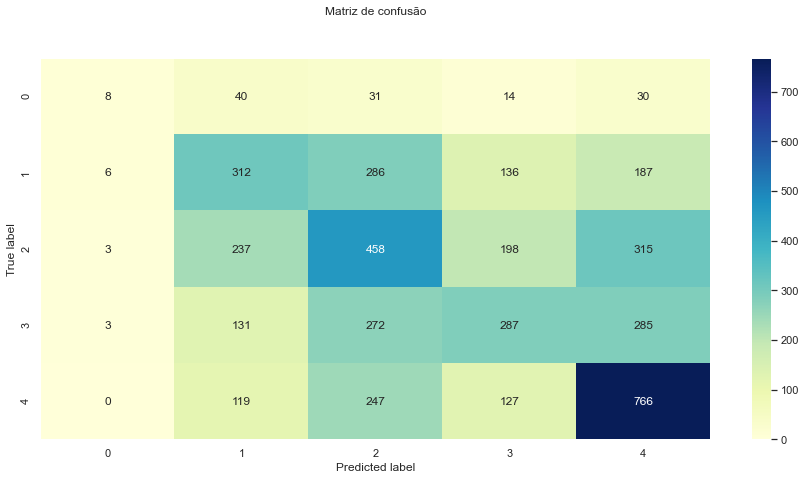

In [94]:
y_pred = model_RFC.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)
p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')

plt.title('Matriz de confusão', y=1.1)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### Curva ROC (train)

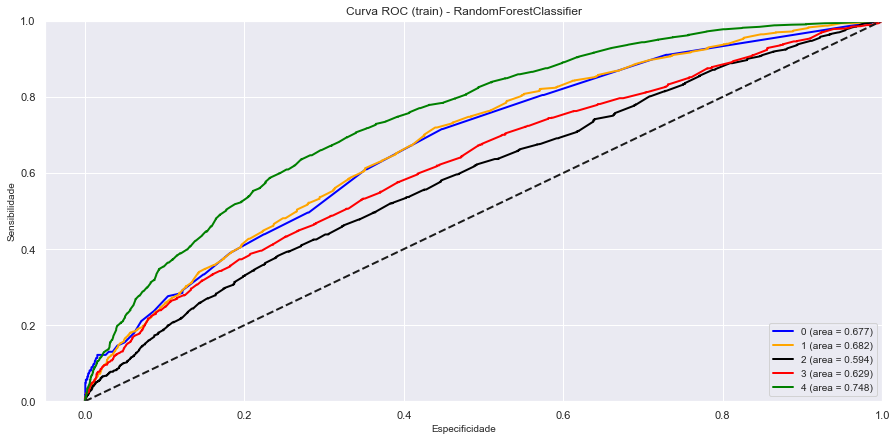

In [95]:
# Definindo algumas variáveis para cálculo da curva ROC
y_score = model_RFC.predict_proba(X_test)
y_test_roc = pd.get_dummies(y_test).values
n_classes = 5
lw = 2

# Calculando a curva ROC para cada classe, cria dicionário
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_roc[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Gerando a curva ROC para cada classe, com cores diferentes para cada classe
plt.figure()
colors = cycle(['blue', 'orange', 'black','red','green'])

for i, color, classes in zip(range(n_classes), colors, model_RFC.classes_):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw, label='{0} (area = {1:0.3f})'.format(classes, roc_auc[i]))

# Configurações de eixos, legenda e título
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('Especificidade', fontsize=10)
plt.ylabel('Sensibilidade', fontsize=10)
plt.title('Curva ROC (train) - RandomForestClassifier')
plt.legend(loc="lower right", fontsize=10)
plt.show()


### Cross Validation (train)

In [96]:
#ajuste hiperparâmetro
#SEED = 1337
#np.random.seed(SEED)
random_state = [5, 6, 7, 8, 9]

for i in random_state:
    np.random.seed()
    cv = StratifiedKFold(n_splits = 5, shuffle = True)
    model = RandomForestClassifier(n_estimators=140,random_state=i)

    x = cross_val_score(model, X_train, y_train, cv = cv, scoring = 'accuracy')
    mean = x.mean()
    dv = x.std()
    print('A acurácia média - random_state {}: {:.2f}%'.format(i, mean*100))
    print('A acurária pode variar no intervalo - random_state {}: [{:.2f}% ~ {:.2f}%]\n'.format(i, (mean - 2*dv)*100, (mean + 2*dv)*100))
    

A acurácia média - random_state 5: 39.47%
A acurária pode variar no intervalo - random_state 5: [38.57% ~ 40.37%]

A acurácia média - random_state 6: 39.79%
A acurária pode variar no intervalo - random_state 6: [37.85% ~ 41.73%]

A acurácia média - random_state 7: 40.41%
A acurária pode variar no intervalo - random_state 7: [39.58% ~ 41.24%]

A acurácia média - random_state 8: 40.40%
A acurária pode variar no intervalo - random_state 8: [37.32% ~ 43.48%]

A acurácia média - random_state 9: 40.11%
A acurária pode variar no intervalo - random_state 9: [38.33% ~ 41.90%]



### Grau de importância dos recursos (train)

Ranking - atributos:
1. [18]: PhotoAmt (0.135018)
2. [1]: Age (0.128504)
3. [6]: Color2 (0.082656)
4. [5]: Color1 (0.080920)
5. [2]: Breed1 (0.074853)
6. [16]: State (0.067297)
7. [3]: Breed2 (0.053791)
8. [9]: FurLength (0.044101)
9. [4]: Gender (0.043161)
10. [7]: Color3 (0.041517)
11. [8]: MaturitySize (0.041144)
12. [15]: Fee (0.040263)
13. [14]: Quantity (0.040103)
14. [11]: Dewormed (0.033963)
15. [10]: Vaccinated (0.031540)
16. [12]: Sterilized (0.030354)
17. [17]: VideoAmt (0.012254)
18. [13]: Health (0.010307)
19. [0]: Type (0.008253)


(-1.0, 19.0)

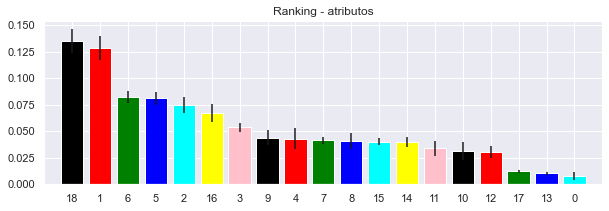

In [97]:
#importância dos atributos
from sklearn.ensemble import RandomForestClassifier

#forest = RandomForestClassifier(max_depth=None, n_estimators = 100) 
forest = RandomForestClassifier(n_estimators=140, random_state=4) 

forest.fit(X,y)

forte = forest.feature_importances_

std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
i = np.argsort(forte)[::-1]

# ranking
print("Ranking - atributos:")

for f in range(X.shape[1]):
    print("%d. [%d]: %s (%f)" % (f + 1, i[f], X.columns.values.tolist()[i[f]], forte[i[f]]))

plt.figure(figsize=(10, 3))
plt.title("Ranking - atributos")
plt.bar(range(X.shape[1]), forte[i],
       color=['black', 'red', 'green', 'blue', 'cyan','yellow','pink'], 
        yerr=std[i], align="center")

plt.xticks(range(X.shape[1]), i)
plt.xlim([-1, X.shape[1]])


-------------------------------------------------------------------------------
# **5.3. RandomForestClassifier** <a class="anchor" id="5.3"></a>

* Ajuste do dataset para melhorar os valores do modelo.

[Topo](#0.1)

In [98]:
#remover - train
train2 = train.drop(['FurLength','Vaccinated','Dewormed','Sterilized','Health','Type'], axis=1) #mantem valores
#train2 = train.drop(['VideoAmt','Type','Health'], axis=1) #cai os valores
#train2 = train.drop(['Color3','VideoAmt','Quantity','Vaccinated','Fee','Dewormed','Sterilized','Health'], axis=1) #cai
#train2 = train.drop(['State','Color1','Color3','VideoAmt','Quantity','Breed2','Fee','Gender','FurLength','MaturitySize','VideoAmt','Type'], axis=1) #cai 
train2.shape

(14993, 14)

In [99]:
Xx, yy = train2.loc[:, train2.columns != 'AdoptionSpeed'], train2['AdoptionSpeed']

In [100]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(Xx, yy, test_size=0.3, random_state=1, stratify=y)

<AxesSubplot:>

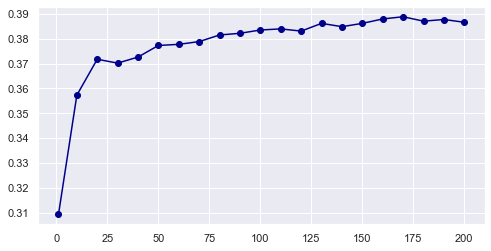

In [101]:
#opcao hiperparametro
results = []
n_options = [1,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200]

for x in n_options:
    #model_RFC = RandomForestClassifier(x, oob_score=True, n_jobs=-1, random_state=0)
    model_RFC = RandomForestClassifier(x, random_state=4)
    model_RFC.fit(X_train2, y_train2)
    
    y_pred = model_RFC.predict(X_test2)
    accuracy = np.mean(y_test==y_pred)
    results.append(accuracy)

plt.figure(figsize=(8,4))
pd.Series(results, n_options).plot(color="darkblue",marker="o")

In [102]:
model_RFC = RandomForestClassifier (n_estimators=170,random_state=4)
#model_RFC = RandomForestClassifier ()
#model_RFC = RandomForestClassifier ( random_state=3)
#model_RFC = RandomForestClassifier (max_depth = None,max_leaf_nodes = None,min_samples_leaf = 1,min_samples_split = 2)
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.3)
model_RFC.fit(X_train2,y_train2) #treinar modelo

#resultado
result = model_RFC.score(X_train2, y_train2)
print("Acurária - treinamento de {:.2f}%".format(result*100))

pred = model_RFC.predict(X_test2)
print("A acurácia de {:.2f}%".format(accuracy_score(y_test2, pred)*100))
 
#print("Matriz de confusão:")
#print(confusion_matrix(y_test2, pred),"\n") 
print("Classification report:")
print(classification_report(y_test2, pred),"\n")


Acurária - treinamento de 95.84%
A acurácia de 38.88%
Classification report:
              precision    recall  f1-score   support

           0       0.32      0.05      0.08       123
           1       0.34      0.32      0.33       927
           2       0.34      0.34      0.34      1211
           3       0.35      0.29      0.31       978
           4       0.47      0.59      0.53      1259

    accuracy                           0.39      4498
   macro avg       0.36      0.32      0.32      4498
weighted avg       0.38      0.39      0.38      4498
 



### Matriz Confusão (train2)

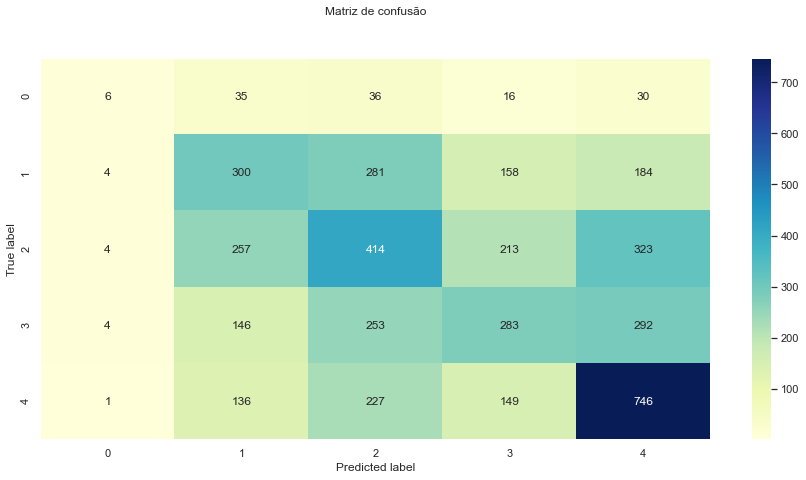

In [103]:
y_pred = model_RFC.predict(X_test2)
cnf_matrix = confusion_matrix(y_test2, y_pred)
p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')

plt.title('Matriz de confusão', y=1.1)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### Curva ROC (train2)

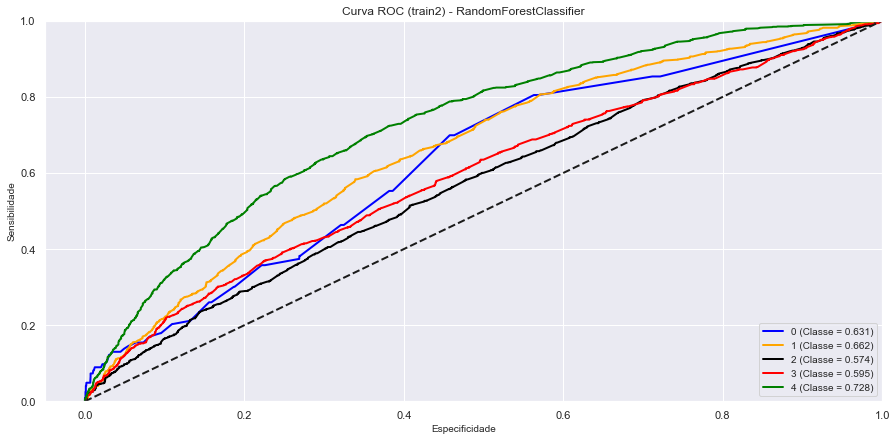

In [104]:
# Definindo algumas variáveis para cálculo da curva ROC
y_score = model_RFC.predict_proba(X_test2)
y_test_roc = pd.get_dummies(y_test2).values
n_classes = 5
lw = 2

# Calculando a curva ROC para cada classe, cria dicionário
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_roc[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Gerando a curva ROC para cada classe, com cores diferentes para cada classe
plt.figure()
colors = cycle(['blue', 'orange', 'black','red','green'])
for i, color, classes in zip(range(n_classes), colors, model_RFC.classes_):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw, label='{0} (Classe = {1:0.3f})'.format(classes, roc_auc[i]))

# Configurações de eixos, legenda e título
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('Especificidade', fontsize=10)
plt.ylabel('Sensibilidade', fontsize=10)
plt.title('Curva ROC (train2) - RandomForestClassifier')
plt.legend(loc="lower right", fontsize=10)
plt.show()

### Cross Validation (train2)

In [105]:
#ajuste hiperparâmetro
random_state = [5, 6, 7, 8, 9]

for i in random_state:
    np.random.seed(10)
    cv = StratifiedKFold(n_splits = 5, shuffle = True)
    model = RandomForestClassifier(n_estimators=170,random_state=i)

    x = cross_val_score(model, X_train2, y_train2, cv = cv, scoring = 'accuracy')
    mean = x.mean()
    dv = x.std()
    print('A acurácia média - random_state {}: {:.2f}%'.format(i, mean*100))
    print('A acurária pode variar no intervalo - random_state {}: [{:.2f}% ~ {:.2f}%]\n'.format(i, (mean - 2*dv)*100, (mean + 2*dv)*100))
    

A acurácia média - random_state 5: 37.80%
A acurária pode variar no intervalo - random_state 5: [36.10% ~ 39.49%]

A acurácia média - random_state 6: 37.68%
A acurária pode variar no intervalo - random_state 6: [35.49% ~ 39.86%]

A acurácia média - random_state 7: 37.07%
A acurária pode variar no intervalo - random_state 7: [34.65% ~ 39.48%]

A acurácia média - random_state 8: 37.44%
A acurária pode variar no intervalo - random_state 8: [36.08% ~ 38.79%]

A acurácia média - random_state 9: 37.62%
A acurária pode variar no intervalo - random_state 9: [36.26% ~ 38.98%]



------------------------------------------------------------------------------
# **6. RESULTADO** <a class="anchor" id="6"></a>

* Balaceamento do dataset (train).

[Topo](#0.1)

<AxesSubplot:xlabel='AdoptionSpeed', ylabel='count'>

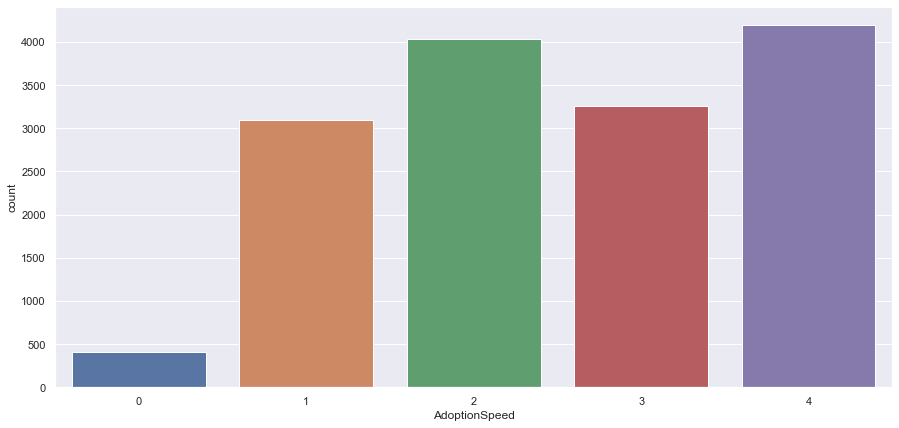

In [106]:
#categorias - atual - desbalanceada
sns.countplot(x='AdoptionSpeed', data = train)

In [107]:
pets_vars = train.columns.tolist()
adopt = ['AdoptionSpeed']
l=[i for i in pets_vars if i not in adopt]


In [108]:
#balancear dataset
new_y = train[adopt]
smote = SMOTE(sampling_strategy = 'not majority', k_neighbors = 100)
new_XX, new_y = smote.fit_resample(train[l], new_y.values.ravel())


<AxesSubplot:ylabel='count'>

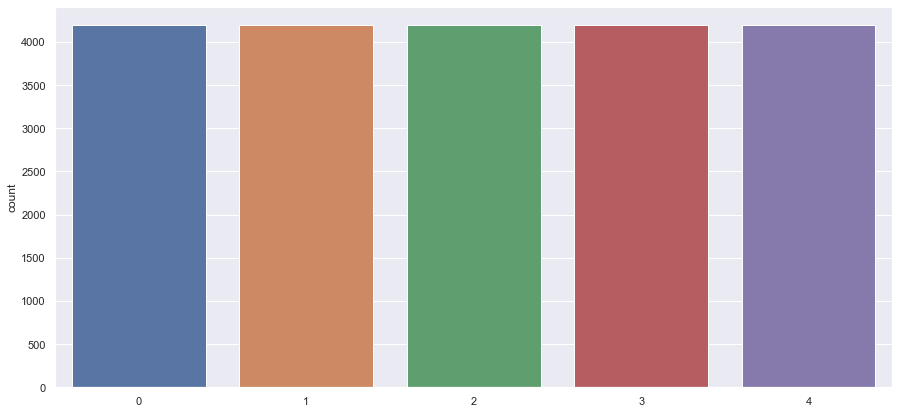

In [109]:
sns.countplot(x=new_y)

In [110]:
XX_train, XX_test, yy_train, yy_test = train_test_split(new_XX, new_y, test_size=0.3, random_state=1)

 ### RandomForestClassifier (balanced)

In [111]:
model_RFC = RandomForestClassifier (class_weight='balanced', n_estimators=1000, random_state=42)

model_RFC.fit(XX_train,yy_train) #treinar modelo

#treina o modelo
result = model_RFC.score(XX_train, yy_train) 
print("Acurária - treinamento de {:.2f}%.".format(result*100))

#testa a acurácia do modelo com os dados de teste
pred = model_RFC.predict(XX_test) 

#gera acurácia do modelo
print("Acurácia de {:.2f}%.".format(accuracy_score(yy_test, pred)*100)) 

print("Classification report:")
print(classification_report(yy_test, pred,digits=2),"\n")  

Acurária - treinamento de 98.62%.
Acurácia de 48.44%.
Classification report:
              precision    recall  f1-score   support

           0       0.70      0.86      0.77      1210
           1       0.44      0.41      0.42      1307
           2       0.33      0.28      0.30      1268
           3       0.40      0.33      0.36      1233
           4       0.48      0.56      0.52      1278

    accuracy                           0.48      6296
   macro avg       0.47      0.49      0.47      6296
weighted avg       0.47      0.48      0.47      6296
 



### Matriz Confusão (balanced)

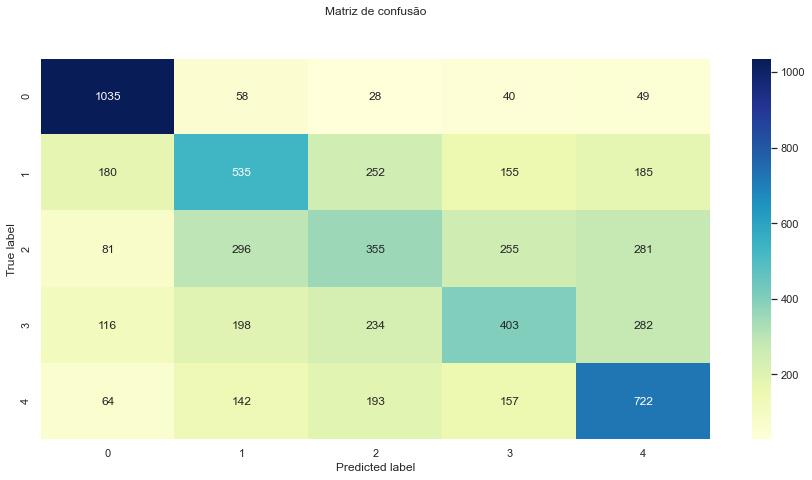

In [112]:

y_pred = model_RFC.predict(XX_test)
cnf_matrix = confusion_matrix(yy_test, y_pred)
p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')

plt.title('Matriz de confusão', y=1.1)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### Grau de importância - recursos (balanced)

Ranking - atributos (balanced):
1. [1]: Age (0.125437)
2. [18]: PhotoAmt (0.123558)
3. [2]: Breed1 (0.097501)
4. [6]: Color2 (0.079285)
5. [5]: Color1 (0.076809)
6. [16]: State (0.070560)
7. [3]: Breed2 (0.056824)
8. [7]: Color3 (0.043551)
9. [9]: FurLength (0.041928)
10. [15]: Fee (0.040996)
11. [4]: Gender (0.038538)
12. [14]: Quantity (0.036987)
13. [11]: Dewormed (0.035546)
14. [8]: MaturitySize (0.035120)
15. [10]: Vaccinated (0.033913)
16. [12]: Sterilized (0.031638)
17. [0]: Type (0.014047)
18. [17]: VideoAmt (0.009599)
19. [13]: Health (0.008164)


(-1.0, 19.0)

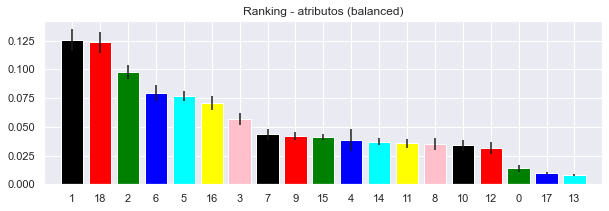

In [113]:
forest = RandomForestClassifier(class_weight='balanced', n_estimators=1000, random_state=42) 

forest.fit(new_XX,new_y)

forte = forest.feature_importances_

std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
i = np.argsort(forte)[::-1]

# ranking
print("Ranking - atributos (balanced):")

for f in range(X.shape[1]):
    print("%d. [%d]: %s (%f)" % (f + 1, i[f], new_XX.columns.values.tolist()[i[f]], forte[i[f]]))

plt.figure(figsize=(10, 3))
plt.title("Ranking - atributos (balanced)")
plt.bar(range(new_XX.shape[1]), forte[i],
       color=['black', 'red', 'green', 'blue', 'cyan','yellow','pink'], 
        yerr=std[i], align="center")

plt.xticks(range(new_XX.shape[1]), i)
plt.xlim([-1, new_XX.shape[1]])

### Cross Validation (balanced)

In [114]:
#ajuste hiperparâmetro
random_state = [5, 6, 7, 8, 9]

for i in random_state:
    np.random.seed(256)
    cv = StratifiedKFold(n_splits = 5, shuffle = True)
    model = RandomForestClassifier(class_weight='balanced',n_estimators=170, random_state=i)

    x = cross_val_score(model, XX_train, yy_train, cv = cv, scoring = 'accuracy')
    mean = x.mean()
    dv = x.std()
    print('A acurácia média - random_state {}: {:.2f}%'.format(i, mean*100))
    print('A acurária pode variar no intervalo - random_state {}: [{:.2f}% ~ {:.2f}%]\n'.format(i, (mean - 2*dv)*100, (mean + 2*dv)*100))
    

A acurácia média - random_state 5: 48.78%
A acurária pode variar no intervalo - random_state 5: [48.14% ~ 49.41%]

A acurácia média - random_state 6: 48.47%
A acurária pode variar no intervalo - random_state 6: [47.39% ~ 49.55%]

A acurácia média - random_state 7: 48.85%
A acurária pode variar no intervalo - random_state 7: [47.84% ~ 49.87%]

A acurácia média - random_state 8: 48.68%
A acurária pode variar no intervalo - random_state 8: [48.10% ~ 49.26%]

A acurácia média - random_state 9: 48.49%
A acurária pode variar no intervalo - random_state 9: [48.23% ~ 48.76%]



### Curva ROC (balanced)

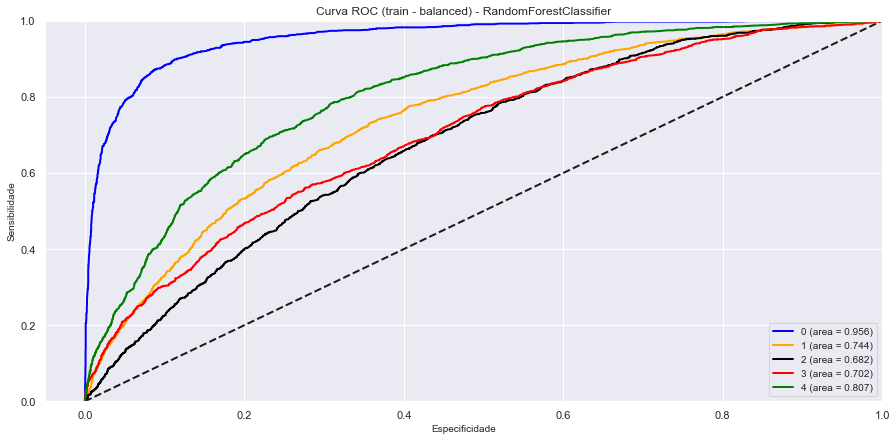

In [115]:
# Definindo algumas variáveis para cálculo da curva ROC
y_score = model_RFC.predict_proba(XX_test)
y_test_roc = pd.get_dummies(yy_test).values
n_classes = 5
lw = 2

# Calculando a curva ROC para cada classe, cria dicionário
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_roc[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Gerando a curva ROC para cada classe, com cores diferentes para cada classe
plt.figure()
colors = cycle(['blue', 'orange', 'black','red','green'])

for i, color, classes in zip(range(n_classes), colors, model_RFC.classes_):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw, label='{0} (area = {1:0.3f})'.format(classes, roc_auc[i]))

# Configurações de eixos, legenda e título
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('Especificidade', fontsize=10)
plt.ylabel('Sensibilidade', fontsize=10)
plt.title('Curva ROC (train - balanced) - RandomForestClassifier')
plt.legend(loc="lower right", fontsize=10)
plt.show()


### Modelos (balanced)

KNeighborsClassifier
Acurária - treinamento de 98.46%
Acurária de 43.20%
Matriz de confusão: 
 [[884 104  89  76  57]
 [143 546 261 209 148]
 [111 273 376 281 227]
 [ 90 215 259 454 215]
 [ 96 200 257 265 460]]
Relatório de classificação: 
               precision    recall  f1-score   support

           0       0.67      0.73      0.70      1210
           1       0.41      0.42      0.41      1307
           2       0.30      0.30      0.30      1268
           3       0.35      0.37      0.36      1233
           4       0.42      0.36      0.39      1278

    accuracy                           0.43      6296
   macro avg       0.43      0.43      0.43      6296
weighted avg       0.43      0.43      0.43      6296

LGBMClassifier
Acurária - treinamento de 96.90%
Acurária de 48.90%
Matriz de confusão: 
 [[1029   56   45   41   39]
 [ 122  560  276  190  159]
 [  54  265  405  285  259]
 [  81  195  274  434  249]
 [  51  155  227  194  651]]
Relatório de classificação: 
           

<AxesSubplot:>

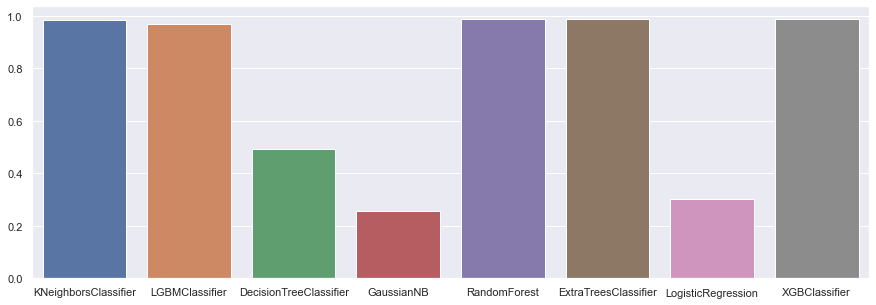

In [116]:
rotular = [
    #{"name": "KNeighborsClassifier", "Objeto": KNeighborsClassifier()}, 
    {"name": "KNeighborsClassifier", "Objeto": KNeighborsClassifier(1)}, 
    
    #{"name": "LGBMClassifier", "Objeto": LGBMClassifier()},
    {"name": "LGBMClassifier", "Objeto": LGBMClassifier(class_weight='balanced',n_estimators=1000, num_leaves=42,max_depth=10)}, 
        
    #{"name": "DecisionTreeClassifier", "Objeto": DecisionTreeClassifier()},
    {"name": "DecisionTreeClassifier", "Objeto": DecisionTreeClassifier(class_weight='balanced',max_depth=10)}, 
    #{"name": "DecisionTreeClassifier", "Objeto": DecisionTreeClassifier(max_depth=None, min_samples_split=2, random_state=0)},
    
    #{"name": "GaussianNB", "Objeto": GaussianNB()},
    {"name": "GaussianNB", "Objeto": GaussianNB(priors=None, var_smoothing=1.0)},
    
    #{"name": "RandomForest", "Objeto": RandomForestClassifier()},
    {"name": "RandomForest", "Objeto": RandomForestClassifier(class_weight='balanced',n_estimators=170, random_state=0)},
       
    #{"name": "ExtraTreesClassifier", "Objeto":ExtraTreesClassifier()},
    {"name": "ExtraTreesClassifier", "Objeto":ExtraTreesClassifier(class_weight='balanced',n_estimators=170, random_state=0)}, 
    
    
    #{"name": "LogisticRegression", "Objeto":LogisticRegression()},
    {"name": "LogisticRegression", "Objeto":LogisticRegression(class_weight='balanced')}, 
    
    #{"name": "XGBClassifier", "Objeto": XGBClassifier()}
    {"name": "XGBClassifier", "Objeto": XGBClassifier(n_estimators=100, max_depth=19)}
]


for clf in rotular:
    clf["Objeto"].fit(XX_train, yy_train)
    y_pred = clf["Objeto"].predict(XX_test)
    
    clf["score"] = clf["Objeto"].score(XX_train,yy_train)
    clf["accuracyScore"] = accuracy_score(yy_test,y_pred)
    
    print("%s"% (clf["name"]))
    print("Acurária - treinamento de {:.2f}%".format(clf["score"]*100))
    print("Acurária de {:.2f}%".format(clf["accuracyScore"]*100))
    print("Matriz de confusão: \n",confusion_matrix(yy_test, y_pred))
    print("Relatório de classificação: \n", classification_report(yy_test, y_pred))
    
names = [clf['name'] for clf in rotular]
scores = [clf['score'] for clf in rotular]

plt.figure(figsize=(15, 5))
sns.barplot(x=names, y=scores)
